# Visualizing the positive semi-definite cone

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib notebook

<IPython.core.display.Javascript object>


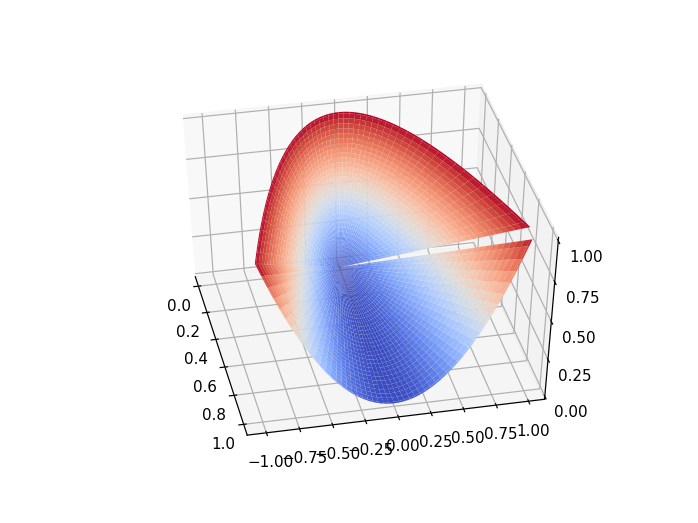

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 1.01, 0.01)
Y_ = np.arange(-1, 1, 0.02)
X, Y_ = np.meshgrid(X, Y_)
Y = X * Y_
Z = X * Y_**2

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0.5, antialiased=True)
ax.plot_surface(Z, Y, X, cmap=cm.coolwarm,
                       linewidth=0.5, antialiased=True)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


plt.show()

# Vizualizing the (inverse) Wishart distribution

## starting with the Wishart distribution and its Laplace Bridge

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wishart, chi2

%matplotlib inline

In [3]:
def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("Psi matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)

In [8]:
# return a cut through a 2D psd_cone, given values for the 
# a_11 and a_22 position of the matrix and a constant rho
def make_2D_psd_cone_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        is_pos_def(matrix)
        xx.append(matrix)
        
    return(xx)

In [13]:
def my_kron_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n2 + l] = A[i,k] * B[j,l]
    
    return(K)
    
def my_box_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n1 + l] = A[i,l] * B[j,k]
    
    return(K)

(301, 2, 2)
(301,)


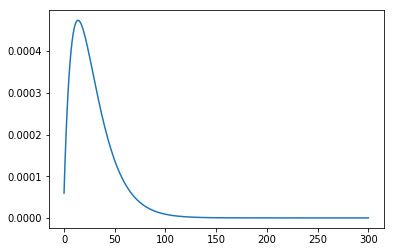

In [9]:
# test the make_2D_psd_cone_cut function
a_11 = np.linspace(0.1, 30.1, 300 +1)
a_22 = np.linspace(0.1, 60.1, 300 +1)
rho = 0

s = np.array([[4,2],
             [2,3]])

xx = make_2D_psd_cone_cut(a_11, a_22, rho)

w = []
print(np.shape(xx))
for x in xx:
    w_ = wishart.pdf(x, df=4, scale=s)
    w.append(w_)
print(np.shape(w))

plt.plot(w);
plt.show()

In [22]:
#define all the relevant functions for the wishart and its transform
from scipy.special import gamma
from scipy.linalg import expm, sqrtm
from scipy.stats import multivariate_normal as mv_norm

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def wishart_pdf(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(X)**((n-p-1)/2) * np.exp(-np.trace(np.linalg.inv(V) @ X)/2)
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_trans_mexp(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(expm(X))**((n-p)/2) * np.exp(-np.trace(np.linalg.inv(V) @ expm(X))/2)
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_trans_square(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(X)**(n-p) * np.exp(-np.trace(np.linalg.inv(V) @ (X@X))/2) * 2**p
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)
   
def multivariate_normal_pdf_test(X, mu, Sigma):
    k = np.shape(X)[0]
    a = (2*np.pi)**(-k/2) * np.linalg.det(Sigma)**(-1/2)
    x_mu = (X-mu).reshape(-1)
    b = np.exp(-1/2 * x_mu.T @ np.linalg.inv(Sigma) @ x_mu)
    return(a*b)

def square_mv_normal_back(X, mu, Sigma):
    X_ = sqrtm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * 0.5 * np.trace(np.linalg.inv(sqrtm(X))))


def wishart_mode(n, p, V):
    return((n-p-1) * V)
    
def wishart_sigma(n, p, V):
    return(2*(n-p-1)*np.kron(V,V))

def wishart_trans_mode(n,p,V):
    return(sqrtm((n-p)*V))


def wishart_trans_sigma_2(V):
    
    n = V.shape[0]
    V_sqrt = sqrtm(V)
    V_inv_sqrt = np.linalg.inv(V_sqrt)
    
    one = np.kron(np.eye(n), V)
    two_ = np.kron(V_inv_sqrt, V_sqrt) + np.eye(n**2)
    two = np.linalg.inv(two_)
    
    R = one @ two
    
    return(R)

def wishart_trans_sigma_3(V):
    
    n = V.shape[0]
    V_sqrt = sqrtm(V)
    V_inv_sqrt = np.linalg.inv(V_sqrt)
    
    one = np.kron(V_sqrt, V_sqrt)
    two = np.kron(np.eye(n), V)
    
    R = one - two
    
    return(R)

def wishart_trans_sigma_3_1(V):
    
    n = V.shape[0]
    V_sqrt = sqrtm(V)
    V_inv_sqrt = np.linalg.inv(V_sqrt)
    
    one = np.kron(V_inv_sqrt, V_inv_sqrt)
    
    K2 = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x = V[k,j] if i == l else 0
                    K2[n*k + j, n*i + l] = x
    
    R = np.linalg.inv(one + K2)
    
    return(R)

def wishart_trans_sigma_4(V):
    
    n = V.shape[0]
    V_sqrt = sqrtm(V)
    V_inv = np.linalg.inv(V)
    V_inv_sqrt = np.linalg.inv(V_sqrt)
    
    one = my_box_product(V_inv_sqrt, V_inv_sqrt)
    
    #two = 1/2 * (my_box_product(np.eye(n), V_inv) + my_box_product(V_inv, np.eye(n)))
    two = my_box_product(np.eye(n), V_inv)
    
    R = np.linalg.inv(one + two)
    
    return(R)

In [23]:
#s = np.array([[4,2],
#             [2,3]])

s = np.array([[5,3],
             [3,4]])


#s = 2*np.eye(2)
is_pos_def(s)

print(np.kron(s, np.eye(2)))
print(my_box_product(np.eye(2), s))

print(wishart_trans_sigma_2(s))
print(wishart_trans_sigma_3(s))
print(wishart_trans_sigma_3_1(s))
print(wishart_trans_sigma_4(s))
print(is_pos_def(wishart_trans_sigma_4(s)))

[[5. 0. 3. 0.]
 [0. 5. 0. 3.]
 [3. 0. 4. 0.]
 [0. 3. 0. 4.]]
[[5. 0. 3. 0.]
 [3. 0. 4. 0.]
 [0. 5. 0. 3.]
 [0. 3. 0. 4.]]
[[2.21215198 1.11620263 0.47974671 0.28784802]
 [1.11620263 1.84008443 0.28784802 0.38379737]
 [0.47974671 0.28784802 2.05223641 1.02025329]
 [0.28784802 0.38379737 1.02025329 1.71215198]]
[[-0.57569605 -1.40405066  1.59594934  0.57569605]
 [-1.40405066 -0.10767916  0.57569605  1.40405066]
 [ 1.59594934  0.57569605 -1.10767916 -1.59594934]
 [ 0.57569605  1.40405066 -1.59594934 -0.57569605]]
[[ 1.59097062 -0.10405066 -0.10405066 -1.69097062]
 [-0.65405066  2.54232084 -0.77430395 -0.39594934]
 [-0.65405066 -0.77430395  2.54232084 -0.39594934]
 [-1.50763729  0.15405066  0.15405066  1.75763729]]
[[2.21215198 1.11620263 0.47974671 0.28784802]
 [0.47974671 0.28784802 2.05223641 1.02025329]
 [1.11620263 1.84008443 0.28784802 0.38379737]
 [0.28784802 0.38379737 1.02025329 1.71215198]]


ValueError: Psi matrix is not positive definite! Matrix: [[2.21215198 1.11620263 0.47974671 0.28784802]
 [0.47974671 0.28784802 2.05223641 1.02025329]
 [1.11620263 1.84008443 0.28784802 0.38379737]
 [0.28784802 0.38379737 1.02025329 1.71215198]]; Eigenvalues: [-1.527636    3.77069063  0.72930937  1.527636  ]

In [19]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_Wishart_bridge(xx, ns, s, p=2, save=False):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = wishart_mode(n1, p=p, V=s)
    mode2 = wishart_mode(n2, p=p, V=s)
    mode3 = wishart_mode(n3, p=p, V=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = wishart_sigma(n1, p=p, V=s)
    sigma2 = wishart_sigma(n2, p=p, V=s)
    sigma3 = wishart_sigma(n3, p=p, V=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)

    w1 = []
    w2 = []
    w3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        w_1 = wishart_pdf(X=x, n=n1, V=s)
        w_2 = wishart_pdf(X=x, n=n2, V=s)
        w_3 = wishart_pdf(X=x, n=n3, V=s)
        w1.append(w_1)
        w2.append(w_2)
        w3.append(w_3)
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(w1_lpa)
        normal2.append(w2_lpa)
        normal3.append(w3_lpa)

    w1 = np.array(w1)
    w2 = np.array(w2)
    w3 = np.array(w3)
    
    rescale_normal1 = np.max(w1)/np.max(normal1)
    rescale_normal2 = np.max(w2)/np.max(normal2)
    rescale_normal3 = np.max(w3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    

    ######### square transformation

    mode1_trans = wishart_trans_mode(n1, p=p, V=s)
    mode2_trans = wishart_trans_mode(n2, p=p, V=s)
    mode3_trans = wishart_trans_mode(n3, p=p, V=s)

    sigma1_trans = wishart_trans_sigma_4(V=s)
    sigma2_trans = wishart_trans_sigma_4(V=s)
    sigma3_trans = wishart_trans_sigma_4(V=s)

    #sigma1_trans = wishart_trans_sigma_entrywise(V=s)
    #sigma2_trans = wishart_trans_sigma_entrywise(V=s)
    #sigma3_trans = wishart_trans_sigma_entrywise(V=s)
    
    is_pos_def(sigma1_trans)
    is_pos_def(sigma2_trans)
    is_pos_def(sigma3_trans)

    w1_trans = []
    w2_trans = []
    w3_trans = []
    w1_lpa_trans = []
    w2_lpa_trans = []
    w3_lpa_trans = []

    for x in xx:
        w_1 = wishart_pdf_trans_square(X=x, n=n1, V=s)
        w_2 = wishart_pdf_trans_square(X=x, n=n2, V=s)
        w_3 = wishart_pdf_trans_square(X=x, n=n3, V=s)
        w1_trans.append(w_1)
        w2_trans.append(w_2)
        w3_trans.append(w_3)
        #
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_trans, Sigma=sigma1_trans)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_trans, Sigma=sigma2_trans)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_trans, Sigma=sigma3_trans)
        w1_lpa_trans.append(w1_lpa)
        w2_lpa_trans.append(w2_lpa)
        w3_lpa_trans.append(w3_lpa)

    #rescale for visibility
    w1_trans = np.array(w1_trans)
    w2_trans = np.array(w2_trans)
    w3_trans = np.array(w3_trans)
    
    rescale_trans1 = np.max(w1_trans)/np.max(w1_lpa_trans)
    rescale_trans2 = np.max(w2_trans)/np.max(w2_lpa_trans)
    rescale_trans3 = np.max(w3_trans)/np.max(w3_lpa_trans)

    w1_lpa_trans = np.array(w1_lpa_trans) * rescale_trans1
    w2_lpa_trans = np.array(w2_lpa_trans) * rescale_trans2 
    w3_lpa_trans = np.array(w3_lpa_trans) * rescale_trans3 

    ######### back transform #########

    w1_back = []
    w2_back = []
    w3_back = []

    for x in xx:
        w1_back.append(square_mv_normal_back(x, mode1_trans, sigma1_trans))
        w2_back.append(square_mv_normal_back(x, mode2_trans, sigma2_trans))
        w3_back.append(square_mv_normal_back(x, mode3_trans, sigma3_trans))
        
    rescale_back1 = np.max(w1)/np.max(w1_back)
    rescale_back2 = np.max(w2)/np.max(w2_back)
    rescale_back3 = np.max(w3)/np.max(w3_back)

    w1_back = np.array(w1_back) * rescale_back1
    w2_back = np.array(w2_back) * rescale_back2 
    w3_back = np.array(w3_back) * rescale_back3 

    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(23, 6))
    axs[0].plot(w1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[0].plot(w2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[0].plot(w3, 'k-', label="Wishart with n={}".format(n3));
    axs[0].plot(normal1, 'r--')#, label="LPA test");
    axs[0].plot(normal2, 'b--')#, label="normal approx of wishart1"'');
    axs[0].plot(normal3, 'k--', label="LPA test");
    axs[0].legend();

    axs[1].plot(w1_trans[:100], 'r')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(w2_trans[:100], 'b')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(w3_trans[:100], 'k', label="Wishart trans");
    axs[1].plot(w1_lpa_trans[:100], 'r--')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(w2_lpa_trans[:100], 'b--')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(w3_lpa_trans[:100], 'k--', label="Laplace trans");
    axs[1].legend();

    axs[2].plot(w1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[2].plot(w2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[2].plot(w3, 'k-', label="Wishart with n={}".format(n3));
    axs[2].plot(w1_back, 'r--')
    axs[2].plot(w2_back, 'b--')
    axs[2].plot(w3_back, 'k--', label='back transform')

    if save:
        plt.savefig('wishart_playground_sqrtm.pdf')
    plt.show();

In [20]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 30.1, 300 +1)
a_22 = np.linspace(0.1, 60.1, 300 +1)

#s = np.array([[4,2],
#             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

s = 2*np.eye(2)
is_pos_def(s)

r = 0
xxt = make_2D_psd_cone_cut(a_11, a_22, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_Wishart_bridge(xx=xxt, ns=[n1,n2,n3], s=s, p=2, save=False)

(301, 2, 2)


ValueError: Psi matrix is not positive definite! Matrix: [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]; Eigenvalues: [ 1. -1.  1.  1.]

(301, 2, 2)


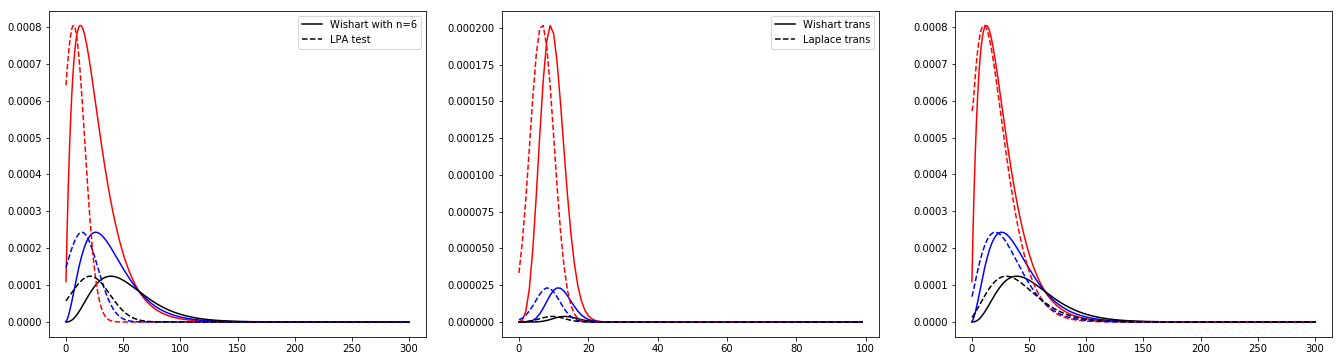

(301, 2, 2)


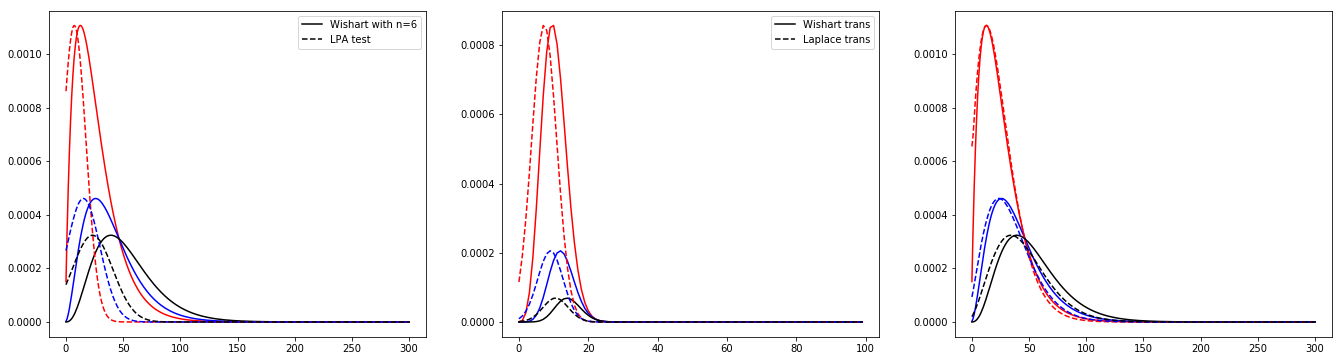

(301, 2, 2)


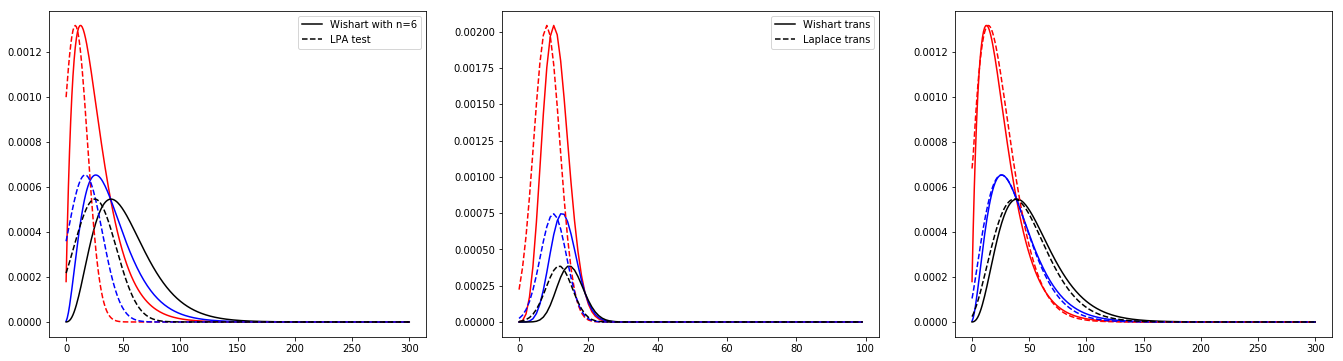

(301, 2, 2)


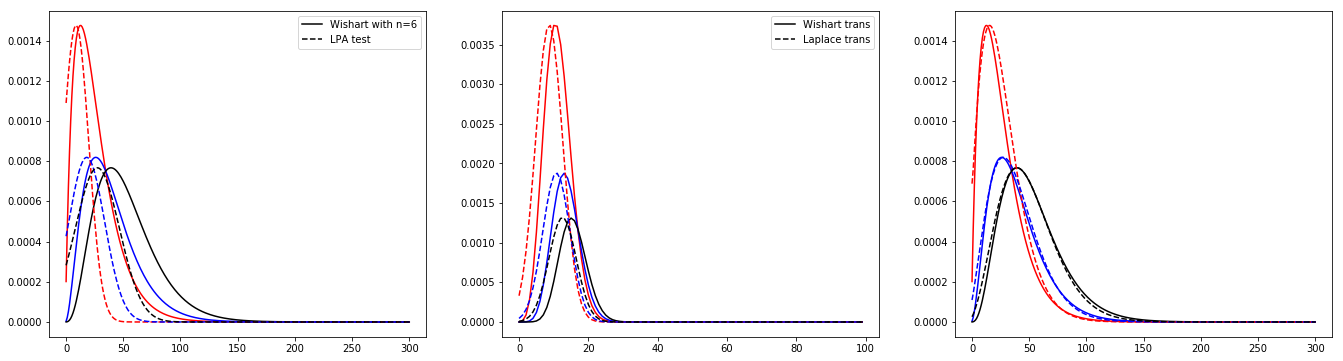

(301, 2, 2)


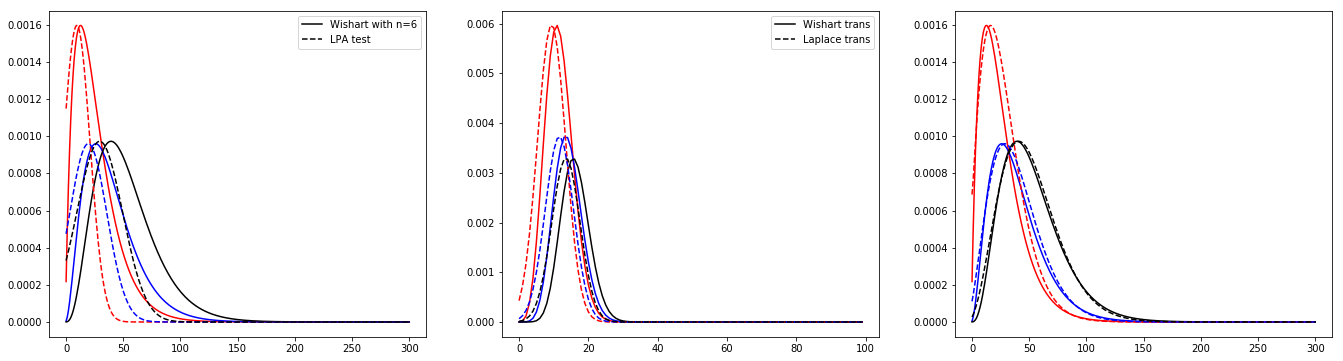

(301, 2, 2)


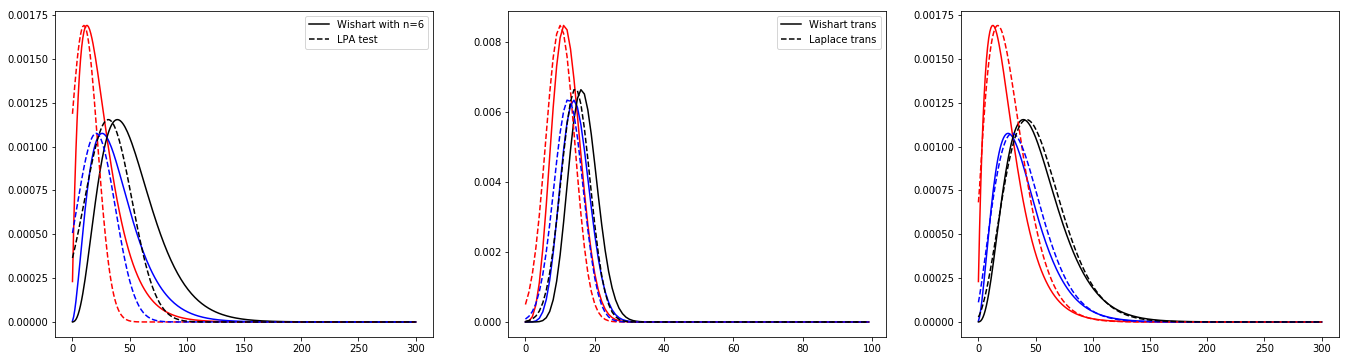

(301, 2, 2)


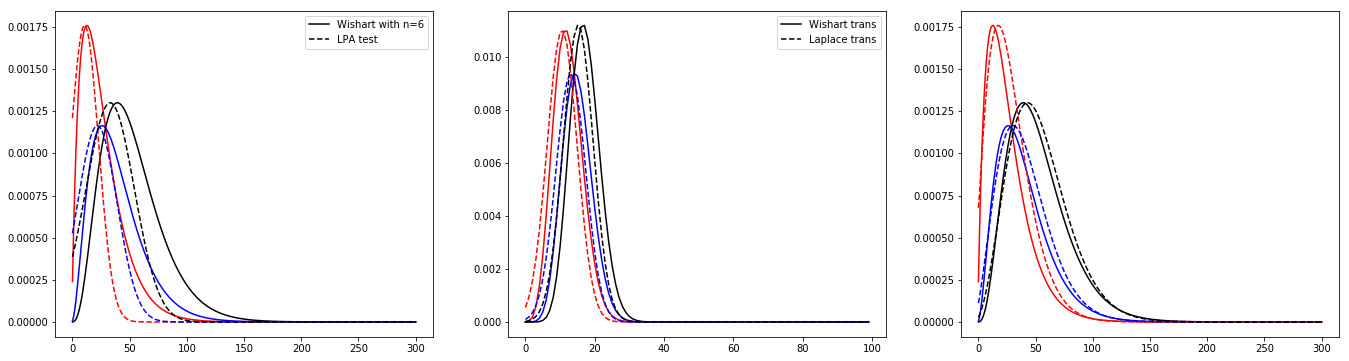

(301, 2, 2)


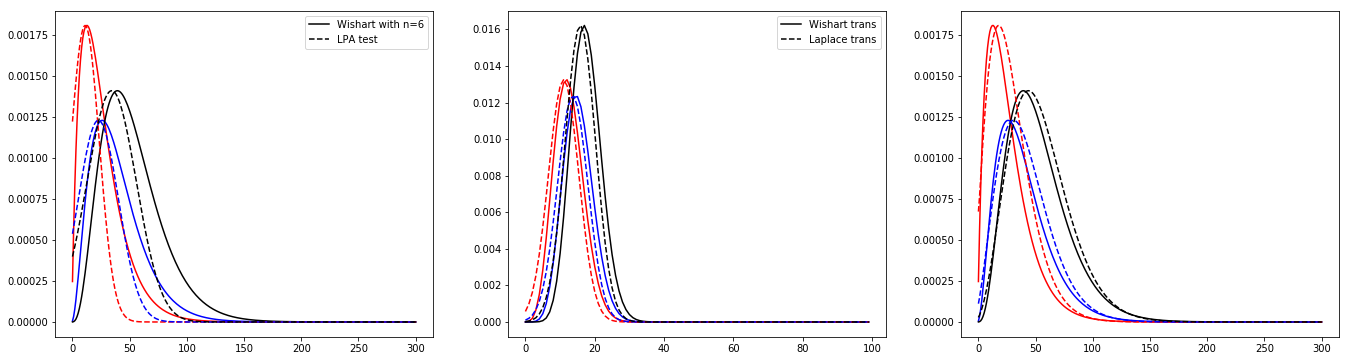

(301, 2, 2)


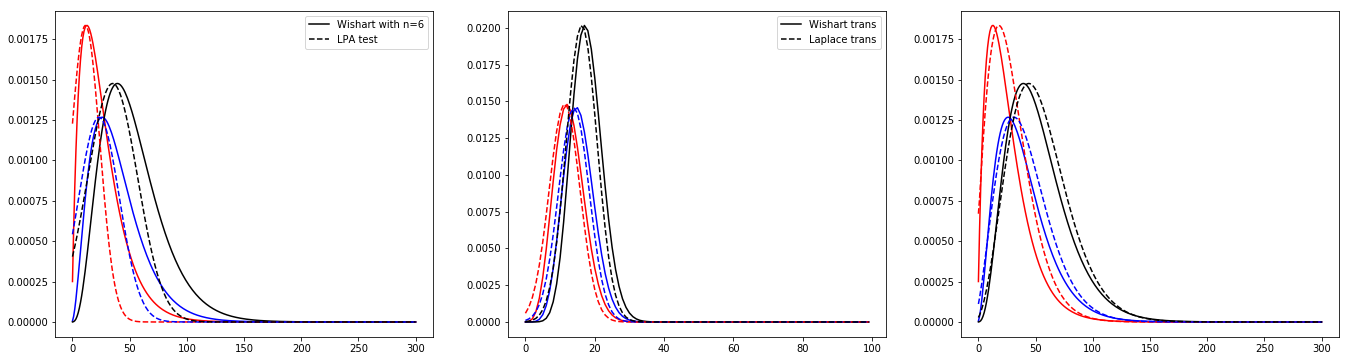

(301, 2, 2)


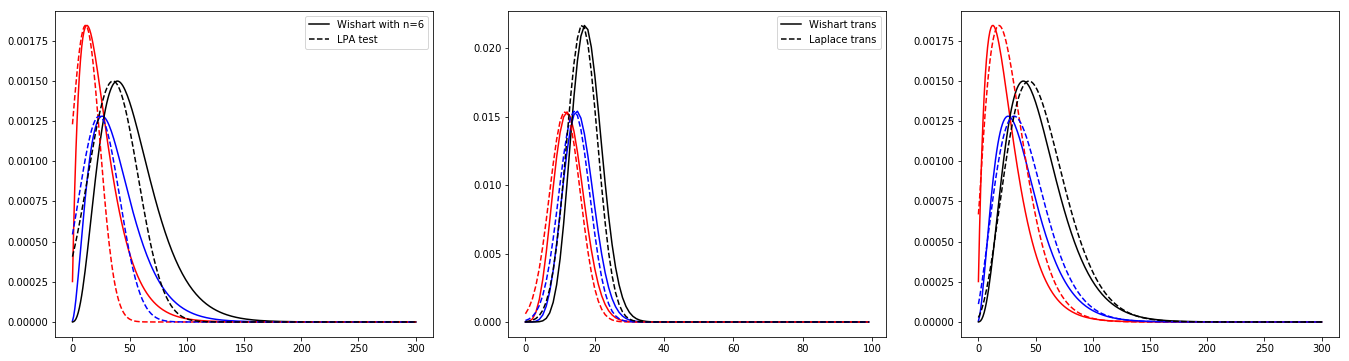

(301, 2, 2)


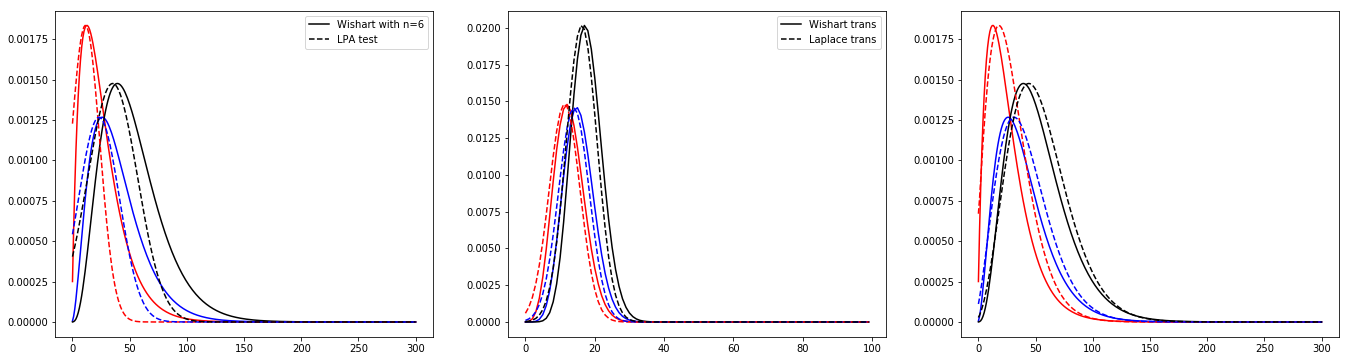

(301, 2, 2)


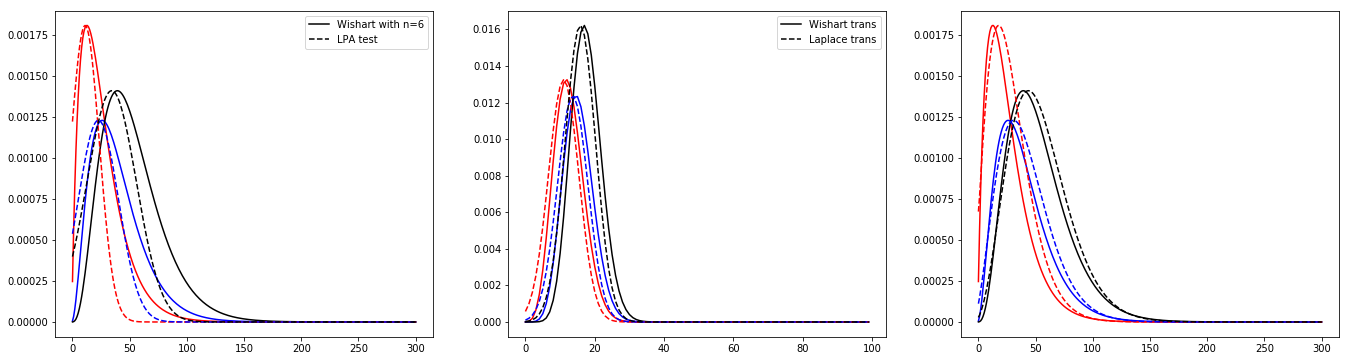

(301, 2, 2)


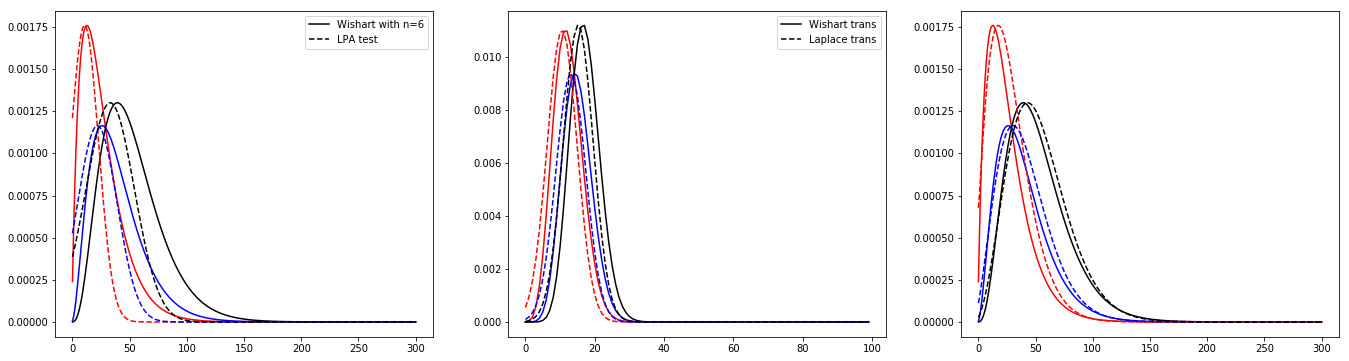

(301, 2, 2)


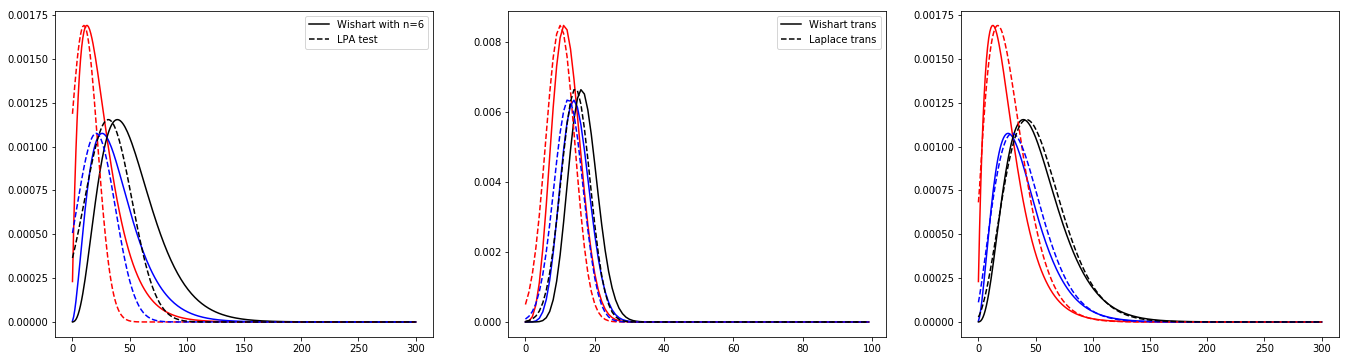

(301, 2, 2)


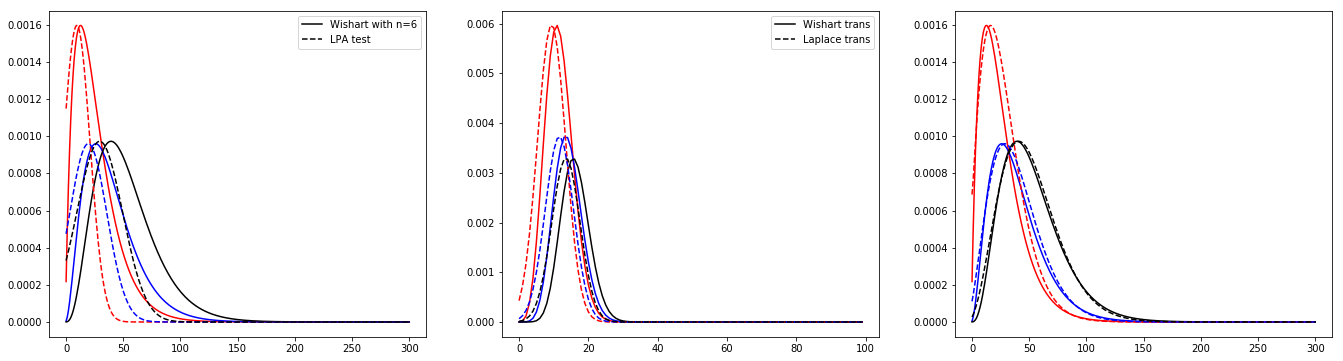

(301, 2, 2)


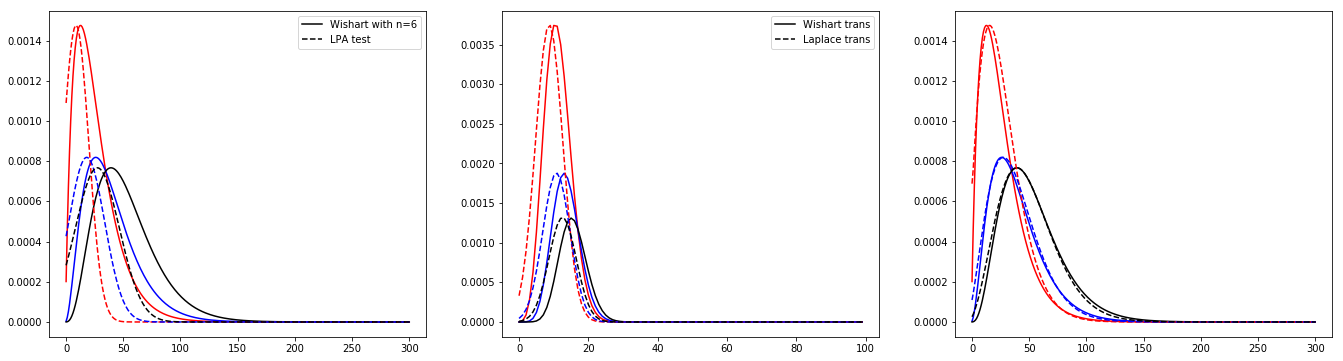

(301, 2, 2)


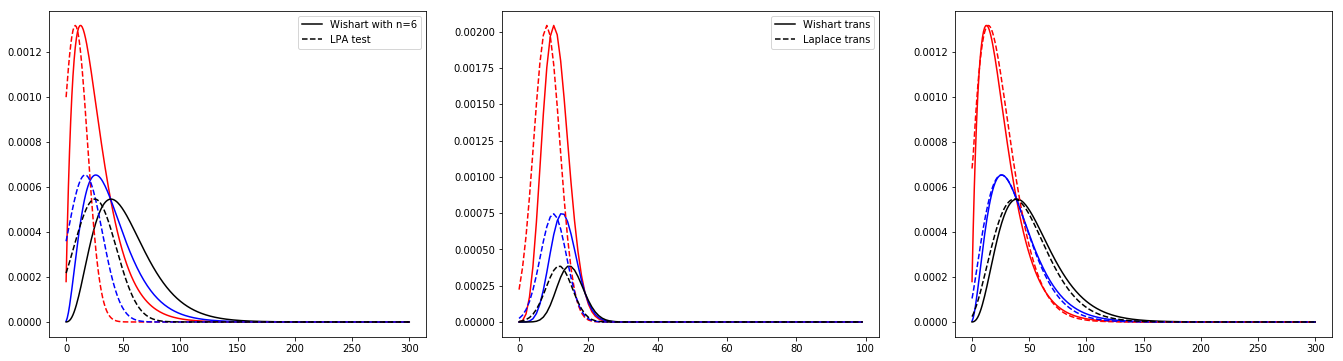

(301, 2, 2)


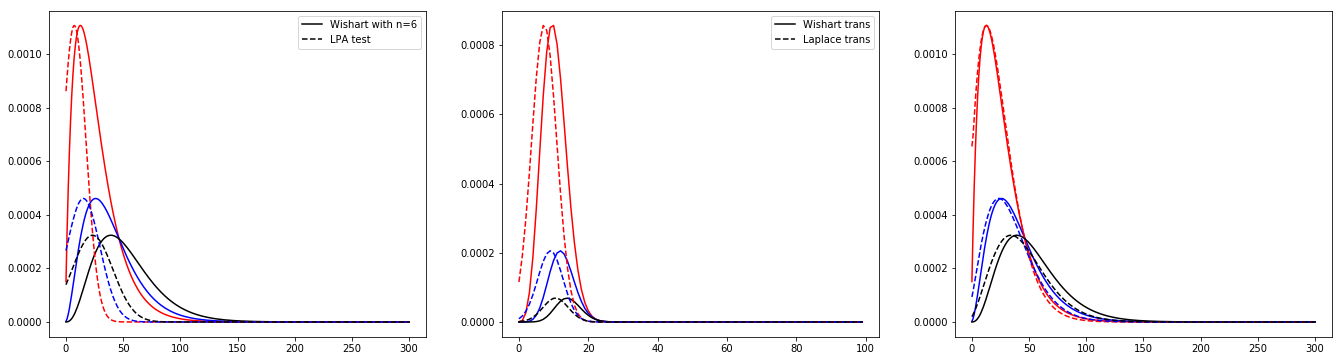

(301, 2, 2)


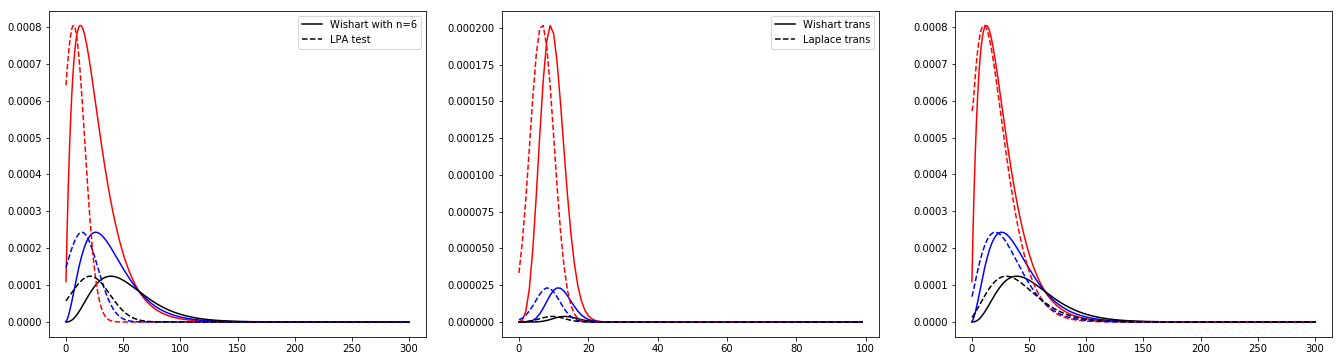

In [334]:
# test the function for multiple values of rho and s

""" values """

s = np.eye(2)*2

#s = np.array([[4,2],
#             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    plot_Wishart_bridge(xx=xx, ns=[n1,n2,n3], s=s, p=2, save=False)

In [11]:
# test different other methods to compare these matrices 
# given by http://www.stat.columbia.edu/~gelman/research/unpublished/Visualization.pdf
# TODO

## continue with the inverse Wishart distribution

In [193]:
from scipy.special import gamma
from scipy.linalg import expm, logm

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def inverse_wishart_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2))
    rest = np.linalg.det(X)**(-(v+p+1)/2) * np.exp(-1/2*np.trace(Psi @ np.linalg.inv(X)))
    return(const * rest)

def inverse_wishart_trans_sqrtm_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2))
    rest =  np.linalg.det(X)**(-(v+p)) * np.exp(-0.5*np.trace(Psi @ np.linalg.inv(X@X)))
    return(const * rest)

def inverse_wishart_mode(nu, p, Psi):
    r = 1/(nu+p+1)*Psi
    return(r.reshape(p,p))

def inverse_wishart_sigma(nu, p, Psi):
    vp1 = nu + p + 1
    
    R = 2/vp1**3 * np.kron(Psi, Psi)
    return(R)    
    

def inverse_wishart_trans_mode(nu, p, Psi):
    r =  sqrtm(1/(nu+p)*Psi)
    #r =  np.sqrt(1/(nu+p)*Psi)
    return(r.reshape(p,p))


In [50]:
def inverse_wishart_trans_sigma_3(nu, p, Psi):
    
    X = inverse_wishart_trans_mode(nu, p, Psi)
    X_inv = np.linalg.inv(X)
    X3_inv = X_inv @ X_inv @ X_inv
    X_inv = np.linalg.inv(X)
    X2 = X@X
    
    part_one = (nu+p) * np.kron(X_inv, X_inv)
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = Psi[i,l] if k == j else 0
                    K[n*k + j, n*i + l] = x1

    K2 = -np.kron(X3_inv, X3_inv.T)
    K3 = np.kron(np.eye(2), X2.T) + np.kron(X, X.T) + np.kron(X2, np.eye(2))
    
    final = -(part_one + (K @ K2 @ K3).T)
    final_inv = np.linalg.inv(final)
    return(final_inv)

In [261]:
def inverse_wishart_trans_sigma_4(nu, p, Psi):
    
    X = inverse_wishart_trans_mode(nu, p, Psi)
    X_inv = np.linalg.inv(X)
    X3_inv = X_inv @ X_inv @ X_inv
    X_inv = np.linalg.inv(X)
    X2_inv = np.linalg.inv(X@X)
    X2 = X@X
    
    part_one = (nu+p) * np.kron(X_inv, X_inv)
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = Psi[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1

    #K2 = np.kron(np.eye(2), X2_inv) + np.kron(X_inv, X_inv) + np.kron(X2_inv, np.eye(2))
    #K3 = np.kron(X_inv, X_inv)
    
    K2 = np.kron(X3_inv, X3_inv)
    K3 = np.kron(np.eye(2), X2) + np.kron(X, X) + np.kron(X2, np.eye(2))
    
    final = (part_one  - (K @ K2 @ K3))
    final_inv = -np.linalg.inv(final)
    return(final_inv)

def inverse_wishart_trans_sigma_4_1(nu, p, Psi):
    
    X = inverse_wishart_trans_mode(nu, p, Psi)
    X_inv = np.linalg.inv(X)
    X3_inv = X_inv @ X_inv @ X_inv
    X_inv = np.linalg.inv(X)
    X2_inv = np.linalg.inv(X@X)
    X2 = X@X
    
    part_one = (nu+p) * np.kron(X_inv, X_inv)
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = Psi[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1

    #K2 = np.kron(np.eye(2), X2_inv) + np.kron(X_inv, X_inv) + np.kron(X2_inv, np.eye(2))
    #K3 = np.kron(X_inv, X_inv)
    
    K2 = np.kron(X3_inv, X3_inv)
    K3 = np.kron(np.eye(2), X2) + np.kron(X, X) + np.kron(X2, np.eye(2))
    
    final = (part_one  - (K2 @ K3 @ K))
    final_inv = -np.linalg.inv(final)
    return(final_inv)

In [364]:
def inverse_wishart_trans_sigma_5(nu, p, Psi):
    
    Psi_sqrt = sqrtm(Psi)
    Psi_inv_sqrt = sqrtm(np.linalg.inv(Psi))
    Psi_inv_sqrt_3 = Psi_inv_sqrt @ Psi_inv_sqrt @ Psi_inv_sqrt
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = Psi[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1
    
    one = (nu+p)**2
    two = np.kron(Psi_inv_sqrt, Psi_inv_sqrt)
    three = K @ (np.kron(Psi_inv_sqrt_3, Psi_inv_sqrt_3) @ (np.kron(Psi, np.eye(n)) + np.kron(Psi_sqrt, Psi_sqrt) + np.kron(np.eye(n), Psi)))
    
    R = one * (two - three)
    R_m_inv = -np.linalg.inv(R)
    
    #print(R_m_inv)
    return(R_m_inv)

In [367]:
def inverse_wishart_trans_sigma_5_1(nu, p, Psi):
    
    Psi_sqrt = sqrtm(Psi)
    Psi_inv_sqrt = sqrtm(np.linalg.inv(Psi))
    Psi_inv_sqrt_3 = Psi_inv_sqrt @ Psi_inv_sqrt @ Psi_inv_sqrt
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = Psi[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1
    
    one = (nu+p)**2
    two = np.kron(Psi_inv_sqrt, Psi_inv_sqrt)
    three = K @ (np.kron(Psi_inv_sqrt_3, Psi_inv_sqrt_3) @ (np.kron(Psi, np.eye(n)) + np.kron(Psi_sqrt, Psi_sqrt) + np.kron(np.eye(n), Psi)))
    
    R = 1/one * (np.linalg.inv(two) - np.linalg.inv(three))
    
    return(R)

In [368]:
si = np.array([[4,2],
             [2,3]])

print(inverse_wishart_trans_sigma_4(4, 2, si))
print(inverse_wishart_trans_sigma_4_1(4, 2, si))
print(inverse_wishart_trans_sigma_5(4, 2, si))
print(inverse_wishart_trans_sigma_5_1(4, 2, si))

[[ 0.05994492 -0.00877873  0.03436183 -0.00438937]
 [-0.00877873  0.06433429 -0.00438937  0.03655651]
 [ 0.03436183 -0.00438937  0.04276401 -0.00658405]
 [-0.00438937  0.03655651 -0.00658405  0.04605603]]
[[ 0.05994492 -0.00877873  0.03436183 -0.00438937]
 [-0.00877873  0.06433429 -0.00438937  0.03655651]
 [ 0.03436183 -0.00438937  0.04276401 -0.00658405]
 [-0.00438937  0.03655651 -0.00658405  0.04605603]]
[[ 0.02266762 -0.11330579 -0.11330579  0.15788794]
 [ 0.05752754 -0.14567948 -0.06711206  0.09108357]
 [ 0.05752754 -0.06711206 -0.14567948  0.09108357]
 [ 0.07247127 -0.07974976 -0.07974976  0.03377873]]
[[0.06737947 0.02818606 0.01219827 0.0066946 ]
 [0.02818606 0.05328644 0.0066946  0.00885097]
 [0.01219827 0.0066946  0.06128034 0.02483876]
 [0.0066946  0.00885097 0.02483876 0.04886095]]


In [360]:
#define big plot function

def plot_inverse_Wishart_bridge(xx, xx_trans, vs, si, p=2, save=False):
    
    v1, v2, v3 = vs
    
    iw1 = []
    iw2 = []
    iw3 = []
    
    normal1 = []
    normal2 = []
    normal3 = []
    
    ##### normal laplace
    mode1 = inverse_wishart_mode(v1, p, Psi=si)
    mode2 = inverse_wishart_mode(v2, p, Psi=si)
    mode3 = inverse_wishart_mode(v3, p, Psi=si)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = inverse_wishart_sigma_2(v1, p=p, Psi=si)
    sigma2 = inverse_wishart_sigma_2(v2, p=p, Psi=si)
    sigma3 = inverse_wishart_sigma_2(v3, p=p, Psi=si)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    for i in range(len(xx)):
        x = xx[i]
        iw_1 = inverse_wishart_pdf(X=x, v=v1, Psi=si)
        iw_2 = inverse_wishart_pdf(X=x, v=v2, Psi=si)
        iw_3 = inverse_wishart_pdf(X=x, v=v3, Psi=si)
        iw1.append(iw_1)
        iw2.append(iw_2)
        iw3.append(iw_3)
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(iw1_lpa)
        normal2.append(iw2_lpa)
        normal3.append(iw3_lpa)


    iw1 = np.array(iw1)
    iw2 = np.array(iw2)
    iw3 = np.array(iw3)
    
    iw1_rescale = np.max(iw1)/np.max(normal1)
    iw2_rescale = np.max(iw2)/np.max(normal2)
    iw3_rescale = np.max(iw3)/np.max(normal3)  

    normal1 = np.array(normal1) * iw1_rescale
    normal2 = np.array(normal2) * iw2_rescale
    normal3 = np.array(normal3) * iw3_rescale

    ######### square transformation

    mode1_trans = inverse_wishart_trans_mode(v1, p=p, Psi=si)
    mode2_trans = inverse_wishart_trans_mode(v2, p=p, Psi=si)
    mode3_trans = inverse_wishart_trans_mode(v3, p=p, Psi=si)

    sigma1_trans = inverse_wishart_trans_sigma_5_1(nu=v1,p=p, Psi=si)
    sigma2_trans = inverse_wishart_trans_sigma_5_1(nu=v2,p=p, Psi=si)
    sigma3_trans = inverse_wishart_trans_sigma_5_1(nu=v3,p=p, Psi=si)
    
    #print(sigma1_trans)
    is_pos_def(sigma1_trans)

    #sigma1_trans = inverse_wishart_trans_sigma_entrywise(V=s)
    #sigma2_trans = inverse_wishart_trans_sigma_entrywise(V=s)
    #sigma3_trans = inverse_wishart_trans_sigma_entrywise(V=s)

    iw1_trans = []
    iw2_trans = []
    iw3_trans = []
    iw1_lpa_trans = []
    iw2_lpa_trans = []
    iw3_lpa_trans = []

    for x in xx_trans:
        iw_1 = inverse_wishart_trans_sqrtm_pdf(X=x, v=v1, Psi=si)
        iw_2 = inverse_wishart_trans_sqrtm_pdf(X=x, v=v2, Psi=si)
        iw_3 = inverse_wishart_trans_sqrtm_pdf(X=x, v=v3, Psi=si)
        iw1_trans.append(iw_1)
        iw2_trans.append(iw_2)
        iw3_trans.append(iw_3)
        #
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_trans, Sigma=sigma1_trans)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_trans, Sigma=sigma2_trans)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_trans, Sigma=sigma3_trans)
        iw1_lpa_trans.append(iw1_lpa)
        iw2_lpa_trans.append(iw2_lpa)
        iw3_lpa_trans.append(iw3_lpa)

    #rescale for visibility
    iw1_trans = np.array(iw1_trans)
    iw2_trans = np.array(iw2_trans)
    iw3_trans = np.array(iw3_trans)
    
    #print("iw1_lpa_trans: ", iw1_lpa_trans)
    
    iw1_trans_rescale = np.max(iw1_trans)/np.max(iw1_lpa_trans)
    iw2_trans_rescale = np.max(iw2_trans)/np.max(iw2_lpa_trans)
    iw3_trans_rescale = np.max(iw3_trans)/np.max(iw3_lpa_trans)

    iw1_lpa_trans = np.array(iw1_lpa_trans) * iw1_trans_rescale
    iw2_lpa_trans = np.array(iw2_lpa_trans) * iw2_trans_rescale
    iw3_lpa_trans = np.array(iw3_lpa_trans) * iw3_trans_rescale

    #"""
    ######### back transform #########

    iw1_back = []
    iw2_back = []
    iw3_back = []
    
    #is_pos_def(sigma1_trans)

    for x in xx:
        iw1_back.append(square_mv_normal_back(x, mode1_trans, sigma1_trans))
        iw2_back.append(square_mv_normal_back(x, mode2_trans, sigma2_trans))
        iw3_back.append(square_mv_normal_back(x, mode3_trans, sigma3_trans))

    iw1_back_rescale = np.max(iw1)/np.max(iw1_back) 
    iw2_back_rescale = np.max(iw2)/np.max(iw2_back) 
    iw3_back_rescale = np.max(iw3)/np.max(iw3_back) 
        
    iw1_back = np.array(iw1_back) * iw1_back_rescale
    iw2_back = np.array(iw2_back) * iw2_back_rescale
    iw3_back = np.array(iw3_back) * iw3_back_rescale
    #"""

    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(23, 6))
    axs[0].plot(iw1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[0].plot(iw2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[0].plot(iw3, 'k-', label="Wishart with n={}".format(n3));
    axs[0].plot(normal1, 'r--')#, label="LPA test");
    axs[0].plot(normal2, 'b--')#, label="normal approx of wishart1"'');
    axs[0].plot(normal3, 'k--', label="LPA test");
    axs[0].legend();

    axs[1].plot(iw1_trans, 'r')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(iw2_trans, 'b')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(iw3_trans, 'k', label="Wishart trans");
    axs[1].plot(iw1_lpa_trans, 'r--')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(iw2_lpa_trans, 'b--')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(iw3_lpa_trans, 'k--', label="Laplace trans");
    axs[1].legend();

    axs[2].plot(iw1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[2].plot(iw2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[2].plot(iw3, 'k-', label="Wishart with n={}".format(n3));
    axs[2].plot(iw1_back, 'r--')
    axs[2].plot(iw2_back, 'b--')
    axs[2].plot(iw3_back, 'k--', label='back transform')


    if save:
        plt.savefig('inverse_wishart_playground_expm.pdf')
    plt.show();

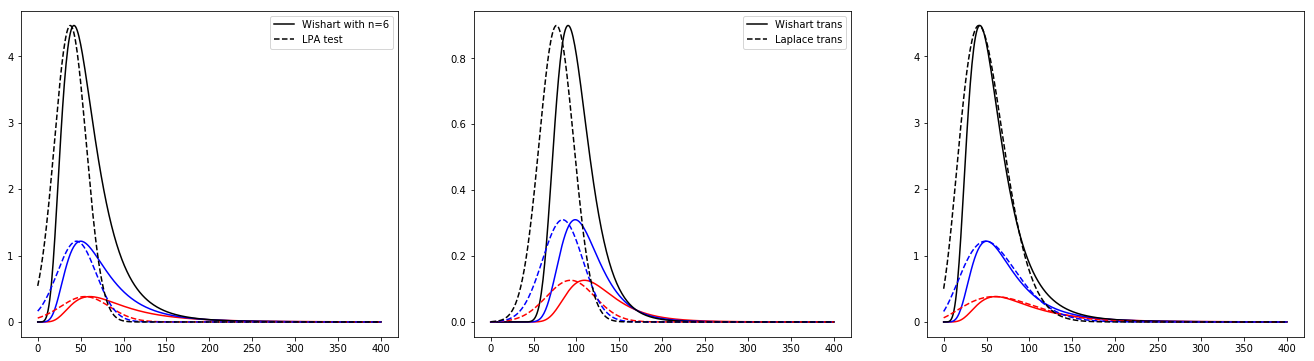

In [361]:
# test inverse wishart on one example

""" values """

a_11 = np.linspace(0.1, 3.1, 400 +1)
a_22 = np.linspace(0.1, 3.1, 400 +1)

si = np.array([[4,2],
             [2,3]])

#si = np.array([[5,3],
#             [3,4]])

#si = np.array([[0.5, 0.1],
#             [0.1, 0.5]])

#si = 2*np.eye(2)

is_pos_def(si)

r = 0.5
xxt_i = make_2D_psd_cone_cut(a_11, a_22, r)

v1 = 3
v2 = 4
v3 = 5

p=2

plot_inverse_Wishart_bridge(xx=xxt_i, xx_trans=xxt_i, vs=[v1,v2,v3], si=si, p=2, save=False)

rho:  -0.9


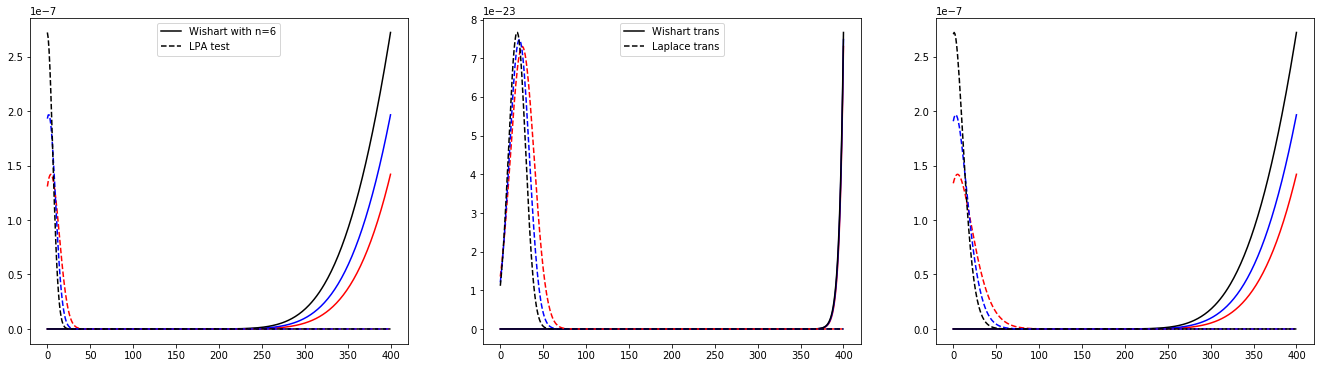

rho:  -0.8


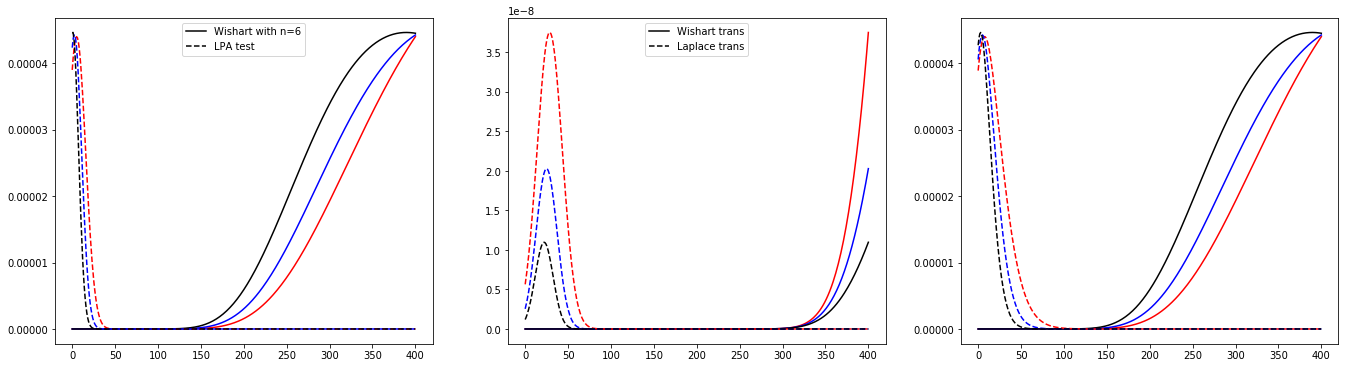

rho:  -0.7


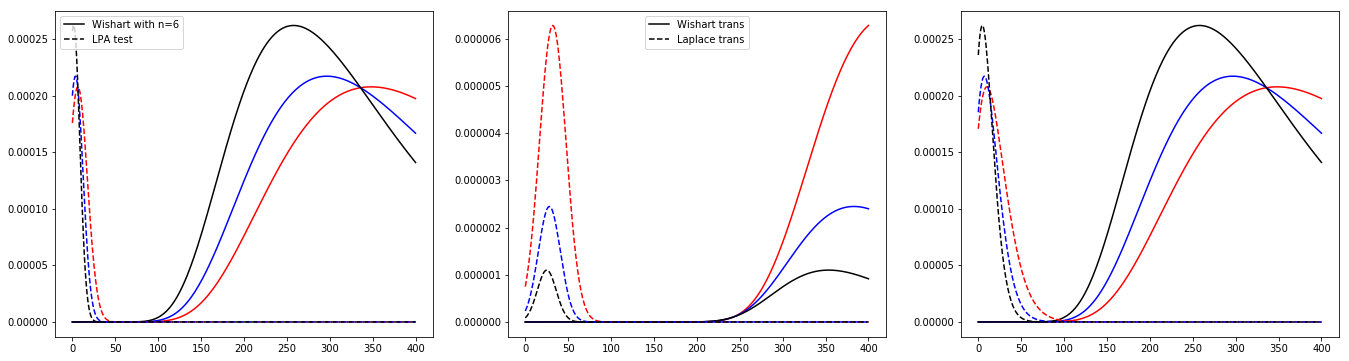

rho:  -0.6


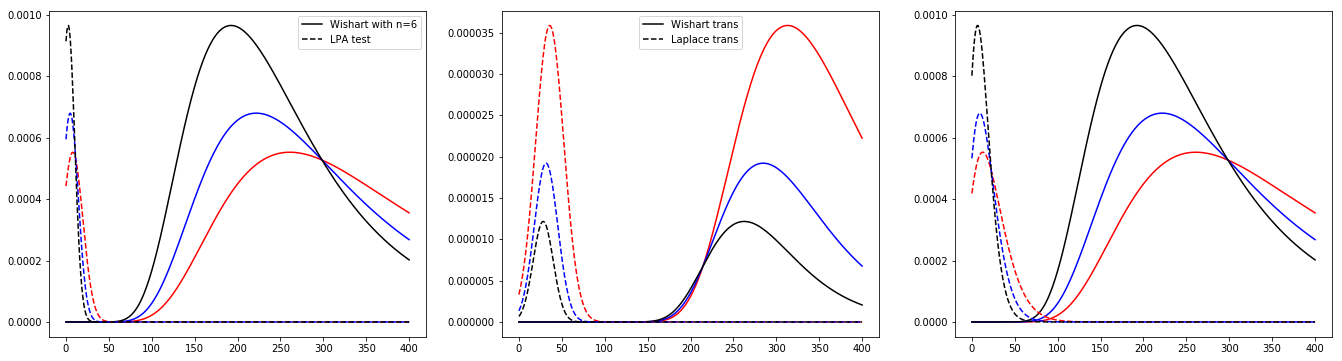

rho:  -0.5


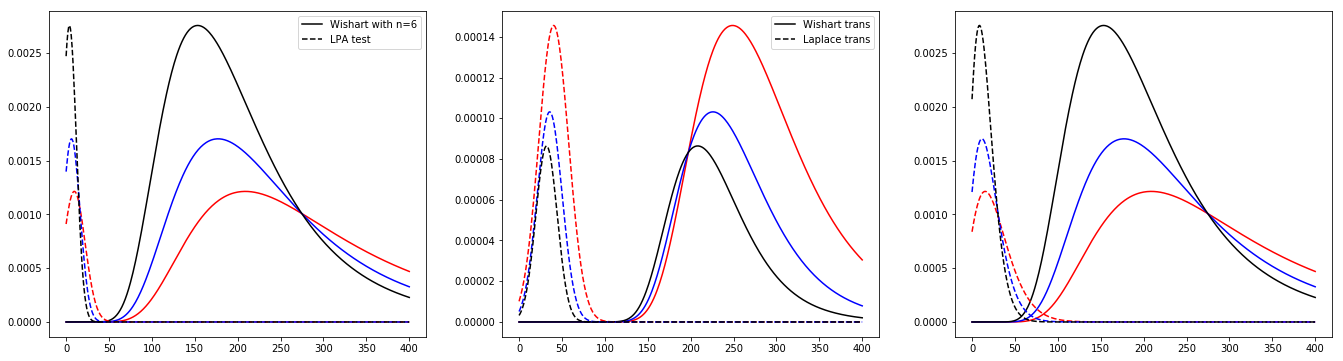

rho:  -0.4


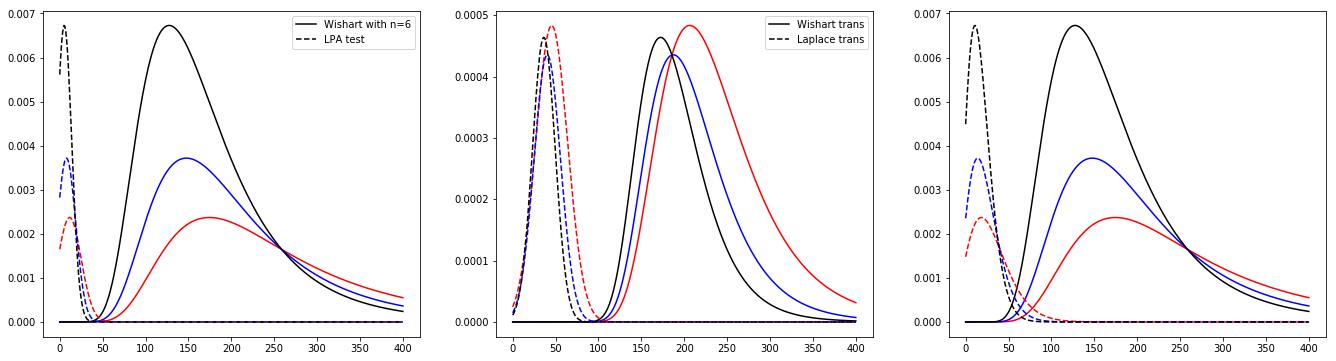

rho:  -0.29999999999999993


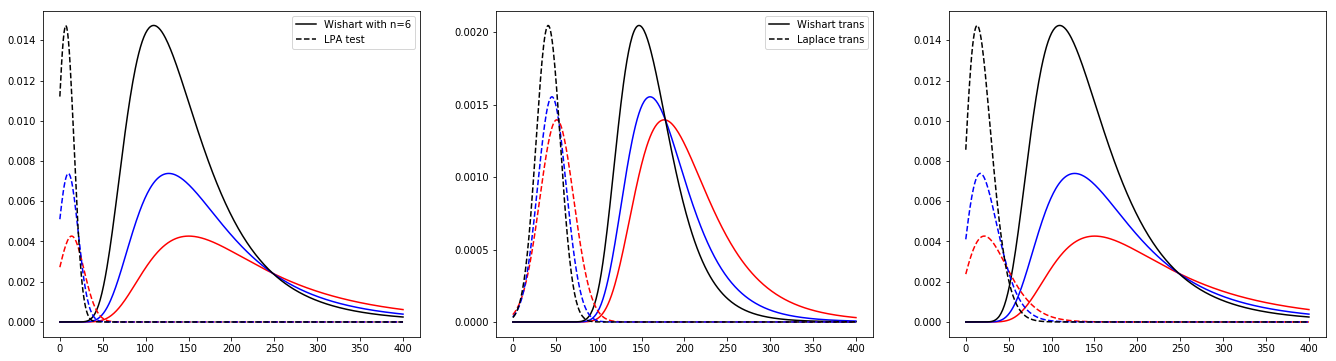

rho:  -0.19999999999999996


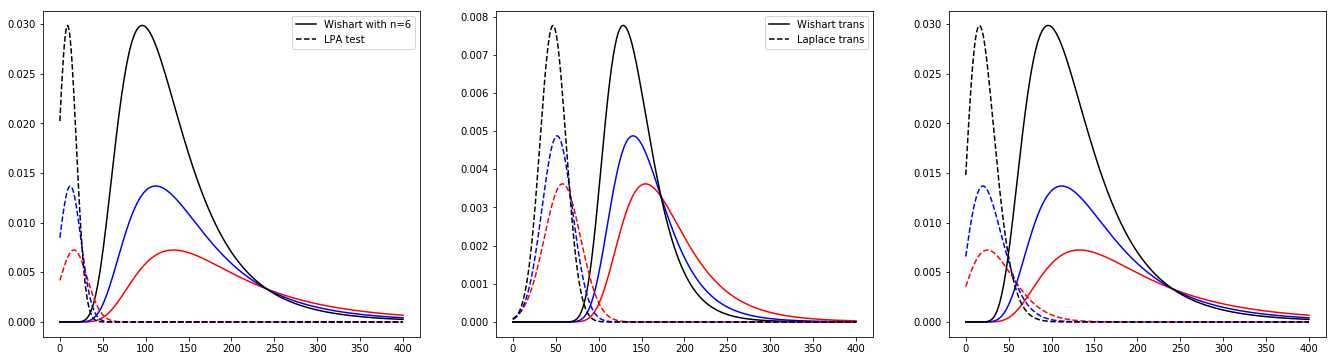

rho:  -0.09999999999999998


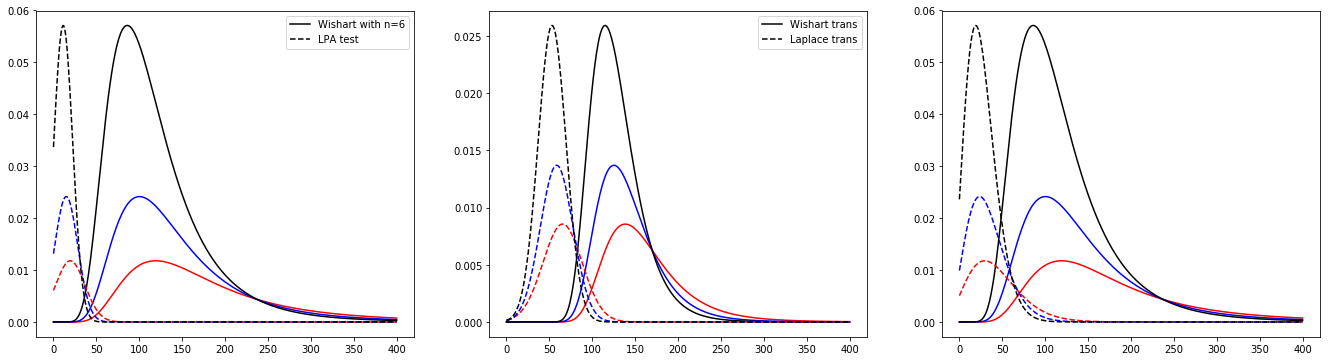

rho:  0.0


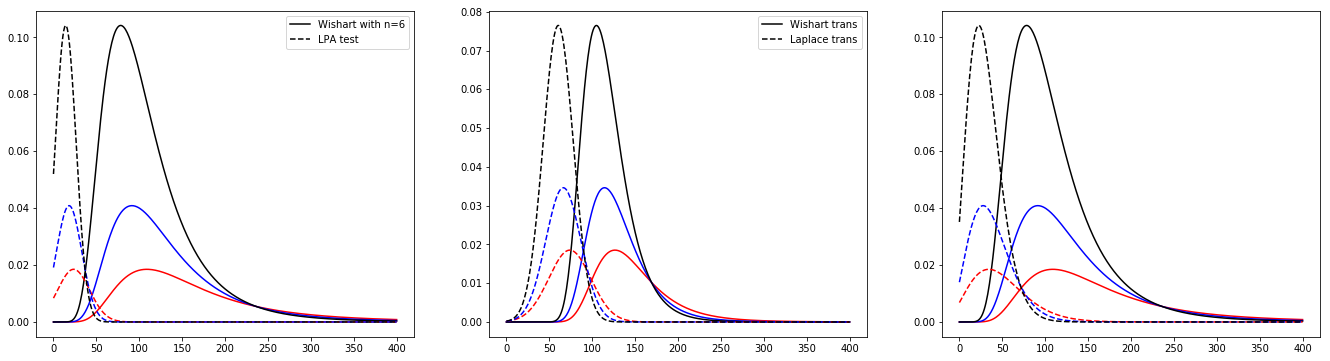

rho:  0.09999999999999998


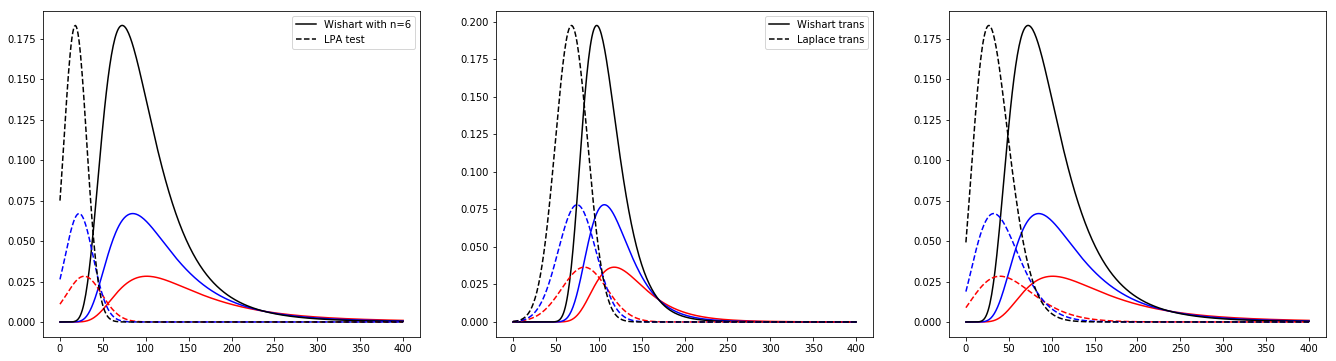

rho:  0.20000000000000007


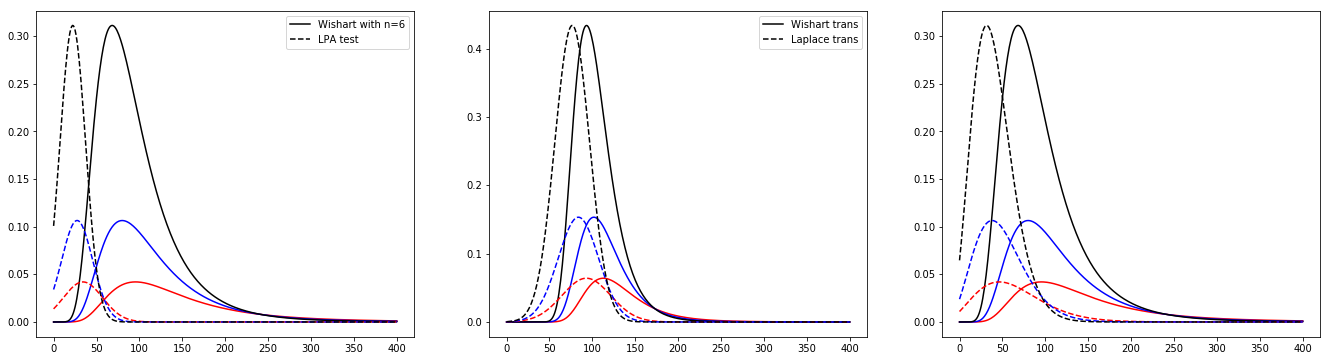

rho:  0.30000000000000016


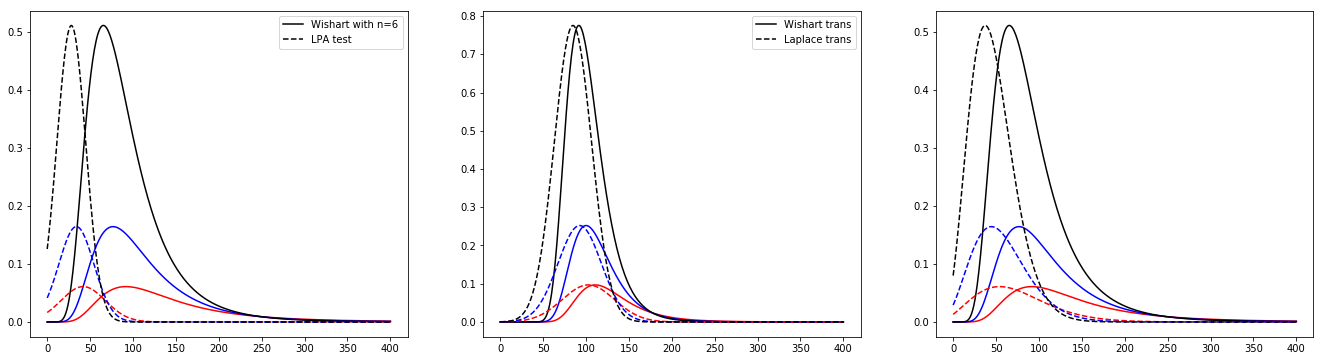

rho:  0.4


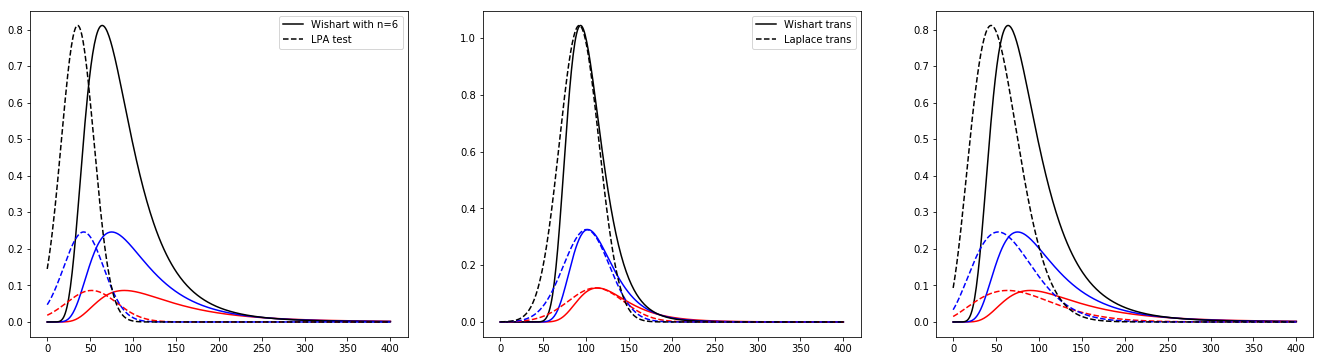

rho:  0.5000000000000001


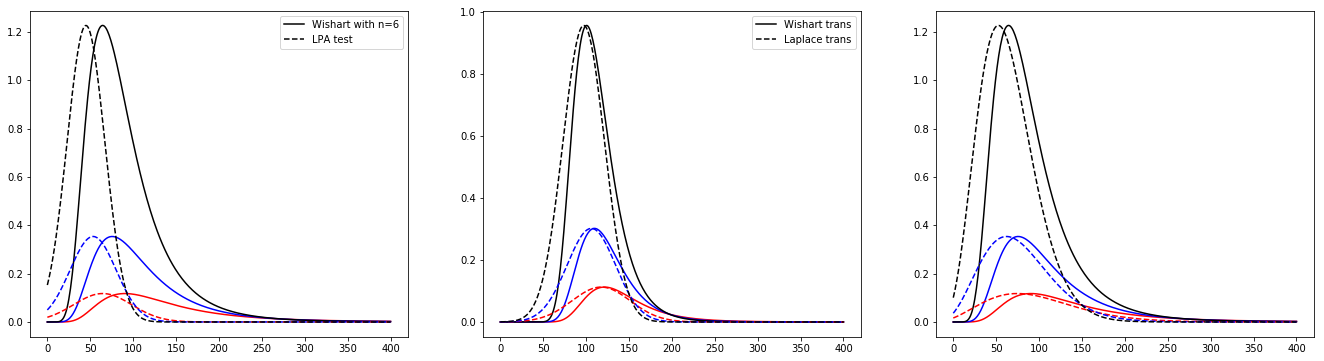

rho:  0.6


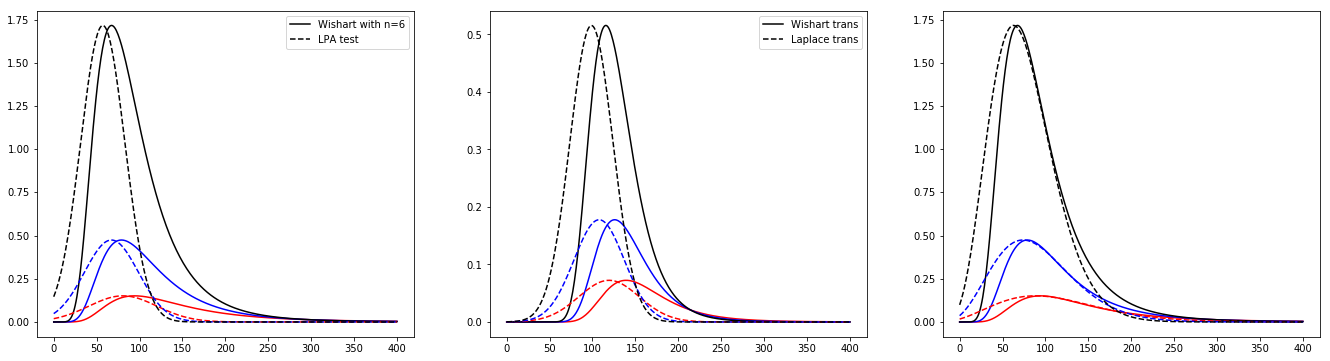

rho:  0.7000000000000001


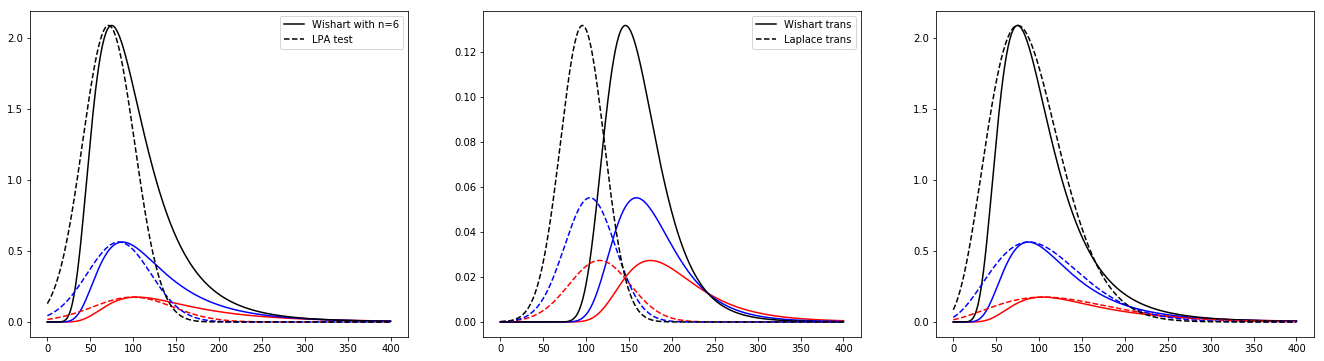

rho:  0.8000000000000002


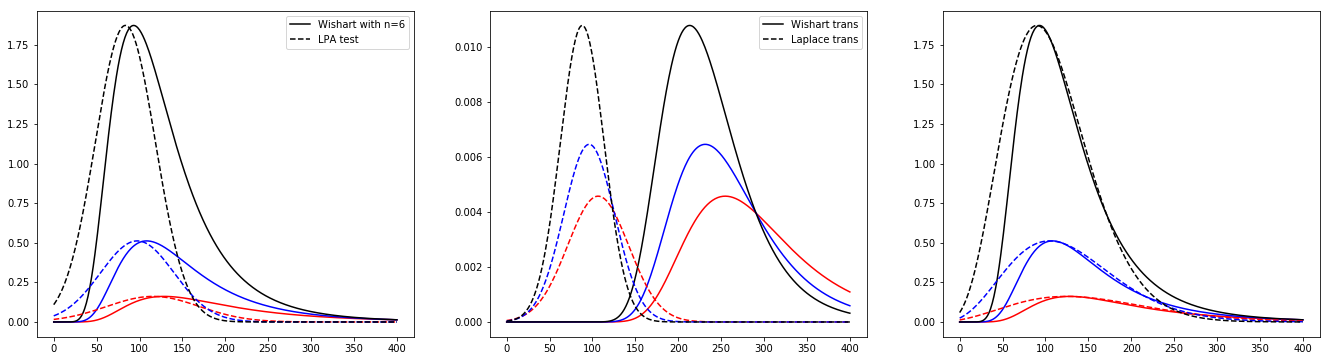

rho:  0.9


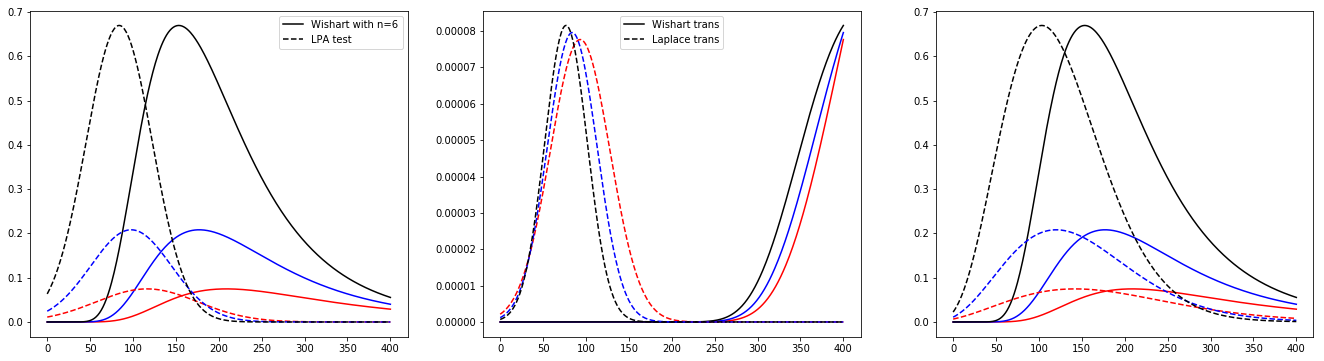

In [362]:
# test inverse wishart on many examples

""" values """

#si = np.eye(2)*2

#si = np.array([[4,2],
#             [2,3]])

#si = np.array([[0.5, 0.1],
#             [0.1, 0.5]])

si = np.array([[6,4],
             [4,5]])

is_pos_def(si)

v1 = 3
v2 = 4
v3 = 5

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    print("rho: ", r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    plot_inverse_Wishart_bridge(xx=xx, xx_trans=xx, vs=[v1,v2,v3], si=si, p=2, save=False)

In [174]:
#test zone:
si = np.array([[4,2],
             [2,3]])

si2 = np.array([[0.5, 0.1],
             [0.1, 0.5]])

si3 = np.array([[6,4],
             [4,5]])

is_pos_def(si)
is_pos_def(si2)
is_pos_def(si3)



True

In [30]:
def test1(X, B):
    n = B.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (X.T@B)[k,i] if l == j else 0
                    x2 = (B@X)[i,l] if k == j else 0
                    K[n*k + j, n*i + l] = x1 + x2
                    
    return(K)


def test2(X, B):
    
    return(np.kron(B,X) + np.kron(X, B))
    #return(2*np.kron(X,B))

In [31]:
print(test1(si, si2))
print(test2(si, si2))

[[4.4 1.3 2.8 1.7]
 [0.  2.2 0.  1.4]
 [1.3 0.  1.7 0. ]
 [2.2 2.6 1.4 3.4]]
[[4.  1.4 1.4 0.4]
 [1.4 3.5 0.4 1.3]
 [1.4 0.4 3.5 1.3]
 [0.4 1.3 1.3 3. ]]


In [47]:
print(inverse_wishart_sigma(4, 2, si))
print(inverse_wishart_sigma2(4, 2, si))

[[0.04733613 0.02366807 0.01280404 0.00640202]
 [0.02366807 0.0355021  0.00640202 0.00960303]
 [0.01280404 0.00640202 0.04093411 0.02046706]
 [0.00640202 0.00960303 0.02046706 0.03070058]]
[[ 0.0349792   0.01601747  0.00515344 -0.00212962]
 [ 0.01601747  0.03076536  0.00166528  0.0043208 ]
 [ 0.00515344  0.00166528  0.03619738  0.01518483]
 [-0.00212962  0.0043208   0.01518483  0.02481006]]


In [78]:
def test3(X, B):
    n = B.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (X@B)[k,i] if l == j else 0
                    x2 = (B@X)[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2
                    
    return(K)

def test3_1(X, B):
    n = B.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    #x1 = (X@B)[k,i] if l == j else 0
                    x2 = (B@X)[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x2
                    
    return(K)

def test3_2(X, B):
    n = B.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (X@B)[k,i] if l == j else 0
                    #x2 = (B@X)[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 
                    
    return(K)

In [74]:
print(test3(si, si2))

[[4.4 1.4 1.4 0. ]
 [1.3 3.9 0.  1.4]
 [1.3 0.  3.9 1.4]
 [0.  1.3 1.3 3.4]]


In [79]:
print(np.kron(si, si2) + np.kron(si2, si))

[[4.  1.4 1.4 0.4]
 [1.4 3.5 0.4 1.3]
 [1.4 0.4 3.5 1.3]
 [0.4 1.3 1.3 3. ]]


In [80]:
print(test3_1(si, si2))
print(test3_2(si, si2))

[[2.2 1.4 0.  0. ]
 [1.3 1.7 0.  0. ]
 [0.  0.  2.2 1.4]
 [0.  0.  1.3 1.7]]
[[2.2 0.  1.4 0. ]
 [0.  2.2 0.  1.4]
 [1.3 0.  1.7 0. ]
 [0.  1.3 0.  1.7]]


In [103]:
def test_4(X, B):
    
    B_inv = np.linalg.inv(B)
    A = np.linalg.inv(X@B_inv@X)
    
    n = B.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (X@B_inv)[k,i] if l == j else 0
                    x2 = (B_inv@X)[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2
                    
    R = np.kron(A, A) @ K
    return(R)

def test_4_1(X, B):
    
    X_inv = np.linalg.inv(X)  
    
    n = B.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (X_inv@B)[k,i] if l == j else 0
                    x2 = (B@X_inv)[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2                  
                  
    R = K @ np.kron(X_inv, X_inv)
    return(R)


In [104]:
print(test_4(si, si))
print(test_4_1(si, si))

[[ 0.28125 -0.1875  -0.1875   0.125  ]
 [-0.1875   0.375    0.125   -0.25   ]
 [-0.1875   0.125    0.375   -0.25   ]
 [ 0.125   -0.25    -0.25     0.5    ]]
[[ 0.28125 -0.1875  -0.1875   0.125  ]
 [-0.1875   0.375    0.125   -0.25   ]
 [-0.1875   0.125    0.375   -0.25   ]
 [ 0.125   -0.25    -0.25     0.5    ]]


In [189]:
def inverse_wishart_sigma_3(nu, p, Psi):
    
    X = inverse_wishart_mode(nu, p, Psi)
    X_inv = np.linalg.inv(X)
    Psi_inv = np.linalg.inv(Psi)
    A = np.linalg.inv(X@Psi_inv@X)
    
    n = X.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (X@Psi_inv)[k,i] if l == j else 0
                    x2 = (Psi_inv@X)[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2
    
    one = (nu + p + 1)/2 * np.kron(X_inv, X_inv)
    two = 1/2 *np.kron(A, A) @ K
    R = -np.linalg.inv(one - two)
    return(R)

def inverse_wishart_sigma_3_1(nu, p, Psi):
    
    X = inverse_wishart_mode(nu, p, Psi)
    X_inv = np.linalg.inv(X)    
    
    n = X.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (X_inv@Psi)[k,i] if l == j else 0
                    x2 = (Psi@X_inv)[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2
                     
    one = (nu + p + 1)/2 * np.kron(X_inv, X_inv)
    two = 1/2 * K @ np.kron(X_inv, X_inv)
    R = -np.linalg.inv(one - two)
    return(R)

def inverse_wishart_sigma_3_2(nu, p, Psi):
    
    X = inverse_wishart_mode(nu, p, Psi)
    X_inv = np.linalg.inv(X)  
    
    Psi_inv = np.linalg.inv(Psi)
    
    vp1 = nu + p + 1
    
    n = X.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (vp1*np.eye(n))[k,i] if l == j else 0
                    x2 = (vp1*np.eye(n))[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2
                     
    one = (nu + p + 1)/2 * np.kron(X_inv, X_inv)
    two = 1/2 * K @ (vp1**2 * np.kron(Psi_inv, Psi_inv))
    R = -np.linalg.inv(one - two)
    return(R)

def inverse_wishart_sigma_3_3(nu, p, Psi):
    
    vp1 = (nu + p + 1)
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (vp1*np.eye(n))[k,i] if l == j else 0
                    x2 = (vp1*np.eye(n))[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2
                    
    one = (vp1/2 * np.eye(n**2) - K)
    two = 1/vp1**2 * np.kron(Psi, Psi)
    R = -(two@np.linalg.inv(one))
    return(R)


def inverse_wishart_sigma_3_4(nu, p, Psi):
    
    vp1 = nu + p + 1
    n = Psi.shape[0]
    
    one = 1/vp1**2 * np.kron(Psi, Psi)
    two = 2 * 1/vp1 * np.eye(n**2)
    
    return(one @ two)

def inverse_wishart_sigma_3_5(nu, p, Psi):
    
    vp1 = nu + p + 1
    
    R = 2/vp1**3 * np.kron(Psi, Psi)
    return(R)

In [190]:
#test zone:
si = np.array([[4,2],
             [2,3]])

si2 = np.array([[0.5, 0.1],
             [0.1, 0.5]])

si3 = np.array([[6,4],
             [4,5]])

is_pos_def(si)
is_pos_def(si2)
is_pos_def(si3)


print(inverse_wishart_sigma_3(4,2, si))
print(inverse_wishart_sigma_3_1(4,2, si))
print(inverse_wishart_sigma_3_2(4,2, si))
print(inverse_wishart_sigma_3_3(4,2, si))
print(inverse_wishart_sigma_3_4(4,2, si))
print(inverse_wishart_sigma_3_5(4,2, si))

[[0.09329446 0.04664723 0.04664723 0.02332362]
 [0.04664723 0.06997085 0.02332362 0.03498542]
 [0.04664723 0.02332362 0.06997085 0.03498542]
 [0.02332362 0.03498542 0.03498542 0.05247813]]
[[0.09329446 0.04664723 0.04664723 0.02332362]
 [0.04664723 0.06997085 0.02332362 0.03498542]
 [0.04664723 0.02332362 0.06997085 0.03498542]
 [0.02332362 0.03498542 0.03498542 0.05247813]]
[[0.09329446 0.04664723 0.04664723 0.02332362]
 [0.04664723 0.06997085 0.02332362 0.03498542]
 [0.04664723 0.02332362 0.06997085 0.03498542]
 [0.02332362 0.03498542 0.03498542 0.05247813]]
[[0.03109815 0.01554908 0.01554908 0.00777454]
 [0.01554908 0.02332362 0.00777454 0.01166181]
 [0.01554908 0.00777454 0.02332362 0.01166181]
 [0.00777454 0.01166181 0.01166181 0.01749271]]
[[0.09329446 0.04664723 0.04664723 0.02332362]
 [0.04664723 0.06997085 0.02332362 0.03498542]
 [0.04664723 0.02332362 0.06997085 0.03498542]
 [0.02332362 0.03498542 0.03498542 0.05247813]]
[[0.09329446 0.04664723 0.04664723 0.02332362]
 [0.0466

In [183]:
def test_5(nu, p, Psi):
    
    vp1 = (nu + p + 1)
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = (vp1*np.eye(n))[k,i] if l == j else 0
                    x2 = (vp1*np.eye(n))[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1 + x2
                    
    A = vp1/2 * np.eye(n**2)
    
    print(A)
    print(K/2)
    print(A - K/2)
    
    C = -1/2*vp1 * np.eye(n**2)
    
    print(C)
    
    C1 = -2/3 * 1/vp1 * np.eye(n**2)
    print(C1)

In [184]:
si = np.array([[5,3,1],
              [3,6,2],
              [1,2,7]])

is_pos_def(si)

test_5(5, 3, si)

[[4.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  4.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  4.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  4.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  4.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  4.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  4.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  4.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  4.5]]
[[9. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 9. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 9. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 9. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 9. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 9. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 9. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 9. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 9.]]
[[-4.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -4.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -4.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -4.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -4.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -4.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -4.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -4.5

In [281]:
si = np.array([[5,3,1],
              [3,6,2],
              [1,2,7]])

is_pos_def(si)

si2 = np.array([[1,2,3],
               [2,3,4],
               [3,4,5]])

A = si @ si2 @ si2
B = si2 @ si @ si2
print(A)
print(B)

print(np.trace(A))
print(np.trace(B))

[[156 225 294]
 [214 310 406]
 [236 344 452]]
[[134 195 256]
 [195 286 377]
 [256 377 498]]
918
918


In [288]:
si = np.array([[4,2],
             [2,3]])

si2 = np.array([[0.5, 0.1],
             [0.1, 0.5]])

si3 = np.array([[6,4],
             [4,5]])

is_pos_def(si)
is_pos_def(si2)
is_pos_def(si3)

True

In [278]:
def test_6(B, X):
    
    n = X.shape[0]
    print(np.kron(np.eye(n), X))
    print(np.kron(X, np.eye(n)))

def test_6_1(B, X):
    
    n = B.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = B[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1
                    
    print(K)
    
    print(np.kron(np.eye(n), si))
    

In [279]:
print(test_6(si, si3))

[[6. 4. 0. 0.]
 [4. 5. 0. 0.]
 [0. 0. 6. 4.]
 [0. 0. 4. 5.]]
[[6. 0. 4. 0.]
 [0. 6. 0. 4.]
 [4. 0. 5. 0.]
 [0. 4. 0. 5.]]
None


In [282]:
print(test_6_1(si, si3))

[[5. 3. 1. 0. 0. 0. 0. 0. 0.]
 [3. 6. 2. 0. 0. 0. 0. 0. 0.]
 [1. 2. 7. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 3. 1. 0. 0. 0.]
 [0. 0. 0. 3. 6. 2. 0. 0. 0.]
 [0. 0. 0. 1. 2. 7. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 5. 3. 1.]
 [0. 0. 0. 0. 0. 0. 3. 6. 2.]
 [0. 0. 0. 0. 0. 0. 1. 2. 7.]]
[[5. 3. 1. 0. 0. 0. 0. 0. 0.]
 [3. 6. 2. 0. 0. 0. 0. 0. 0.]
 [1. 2. 7. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 3. 1. 0. 0. 0.]
 [0. 0. 0. 3. 6. 2. 0. 0. 0.]
 [0. 0. 0. 1. 2. 7. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 5. 3. 1.]
 [0. 0. 0. 0. 0. 0. 3. 6. 2.]
 [0. 0. 0. 0. 0. 0. 1. 2. 7.]]
None


In [291]:
def test_6_2(X):
    
    n = X.shape[0]
    X_inv = np.linalg.inv(X)
    X_sqrt = sqrtm(X)
    X_sqrt_inv = np.linalg.inv(X_sqrt)
    
    A = np.kron((X_sqrt_inv@X_sqrt_inv@X_sqrt_inv), X_sqrt)
    B = np.kron(X_inv, np.eye(n))
    C = np.kron((X_inv@X_inv), np.eye(n))
    
    print("A:", A)
    print("B:", B)
    print("C: ", C)
    

In [292]:
test_6_2(si)

A: [[ 0.51227241  0.15004111 -0.46867732 -0.13727241]
 [ 0.15004111  0.43725185 -0.13727241 -0.40004111]
 [-0.46867732 -0.13727241  0.74661107  0.21867732]
 [-0.13727241 -0.40004111  0.21867732  0.63727241]]
B: [[ 0.375  0.    -0.25  -0.   ]
 [ 0.     0.375 -0.    -0.25 ]
 [-0.25  -0.     0.5    0.   ]
 [-0.    -0.25   0.     0.5  ]]
C:  [[ 0.203125  0.       -0.21875  -0.      ]
 [ 0.        0.203125 -0.       -0.21875 ]
 [-0.21875  -0.        0.3125    0.      ]
 [-0.       -0.21875   0.        0.3125  ]]


In [305]:
def inverse_wishart_trans_sigma_5(nu, p, Psi):
    
    Psi_sqrt = sqrtm(Psi)
    Psi_inv_sqrt = sqrtm(np.linalg.inv(Psi))
    Psi_inv_sqrt_3 = Psi_inv_sqrt @ Psi_inv_sqrt @ Psi_inv_sqrt
    
    n = Psi.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = Psi[l,j] if k == i else 0
                    K[n*k + j, n*i + l] = x1
    
    one = (nu+p)**2
    two = np.kron(Psi_inv_sqrt, Psi_inv_sqrt)
    three = K @ (np.kron(Psi_inv_sqrt_3, Psi_inv_sqrt_3) @ (np.kron(Psi, np.eye(n)) + np.kron(Psi_sqrt, Psi_sqrt) + np.kron(np.eye(n), Psi)))
    
    R = one * (two - three)
    R_m_inv = -np.linalg.inv(R)
    
    #print(R_m_inv)
    return(R_m_inv)

def inverse_wishart_trans_sigma_5_1(nu, p, Psi):
    
    n = Psi.shape[0]
    Psi_sqrt = sqrtm(Psi)
    Psi_sqrt_inv = np.linalg.inv(Psi_sqrt)
    
    one = 1/(nu+p)**2
    two = np.kron(Psi, np.eye(n))
    three_ = np.kron(Psi_sqrt_inv, Psi_sqrt) + np.eye(n**2)
    three = np.linalg.inv(three_)
    R = one * two @ three
    return(R)

def inverse_wishart_trans_sigma_5_2(nu, p, Psi):
    
    n = Psi.shape[0]
    Psi_sqrt = sqrtm(Psi)
    Psi_sqrt_inv = np.linalg.inv(Psi_sqrt)
    Psi_inv = np.linalg.inv(Psi)
    
    one = 1/(nu+p)**2
    two = np.kron((Psi_sqrt @ Psi_sqrt @ Psi_sqrt), Psi_sqrt_inv) + np.kron(Psi@Psi, Psi_inv)
    
    R = one * two 
    return(R)

In [304]:
print(inverse_wishart_trans_sigma_5(4, 2, si))
print(inverse_wishart_trans_sigma_5_1(4, 2, si))
print(inverse_wishart_trans_sigma_5_2(4, 2, si))

[[ 0.05994492 -0.00877873  0.03436183 -0.00438937]
 [-0.00877873  0.06433429 -0.00438937  0.03655651]
 [ 0.03436183 -0.00438937  0.04276401 -0.00658405]
 [-0.00438937  0.03655651 -0.00658405  0.04605603]]
[[ 0.05994492 -0.00877873  0.03436183 -0.00438937]
 [-0.00877873  0.06433429 -0.00438937  0.03655651]
 [ 0.03436183 -0.00438937  0.04276401 -0.00658405]
 [-0.00438937  0.03655651 -0.00658405  0.04605603]]
[[ 0.34994942 -0.18748385  0.23473136 -0.1277272 ]
 [-0.18748385  0.44369135 -0.1277272   0.29859496]
 [ 0.23473136 -0.1277272   0.23258374 -0.12362025]
 [-0.1277272   0.29859496 -0.12362025  0.29439387]]


In [336]:
import sys
sys.getrecursionlimit()

3000

In [2]:
A = np.array([[1,2],
    [3,4],
    [5,6],
    [7,8]])

B = np.array([[9,7,0,0],
              [4,5,0,0],
              [0,0,1,2],
              [0,0,7,6]])

In [4]:
A.T @ B

array([[21, 22, 54, 52],
       [34, 34, 62, 60]])

In [15]:
print(A[0:2])
print(B[0:2])
print(A[0:2].T @ B[0:2])

print(A[2:4])
print(B[2:4])
print(A[2:4].T @ B[2:4])

print(A[0:2].T @ B[0:2] + A[2:4].T @ B[2:4])

[[1 2]
 [3 4]]
[[9 7]
 [4 5]]
[[21 22]
 [34 34]]
[[5 6]
 [7 8]]
[[0 0 1 2]
 [0 0 7 6]]
[[ 0  0 54 52]
 [ 0  0 62 60]]
[[21 22 54 52]
 [34 34 62 60]]


In [12]:
A.T @ B @ A

array([[ 721,  870],
       [ 866, 1056]])

In [16]:
A[0:2].T @ B[0:2,0:2] @ A[0:2] + A[2:4].T @ B[2:4,2:4] @ A[2:4]

array([[ 721,  870],
       [ 866, 1056]])

In [47]:
#kronecker stuff

A = np.array([[1,2],
    [3,4],
    [5,6],
    [7,8]])

U = np.array([[4,3],
            [2,1]])

V = np.array([[5,6],
            [3,9]])

K = np.kron(U, V)

print(A.shape, V.shape)
print(K)

print(A.T @ K @ A)


print(np.kron((A @ V @ A.T), U))

(4, 2) (2, 2)
[[20 24 15 18]
 [12 36  9 27]
 [10 12  5  6]
 [ 6 18  3  9]]
[[2886 3632]
 [3784 4760]]
[[ 236  177  516  387  796  597 1076  807]
 [ 118   59  258  129  398  199  538  269]
 [ 540  405 1188  891 1836 1377 2484 1863]
 [ 270  135  594  297  918  459 1242  621]
 [ 844  633 1860 1395 2876 2157 3892 2919]
 [ 422  211  930  465 1438  719 1946  973]
 [1148  861 2532 1899 3916 2937 5300 3975]
 [ 574  287 1266  633 1958  979 2650 1325]]


In [44]:
one = (A @ V @ A.T)
print(one)

[[  59  129  199  269]
 [ 135  297  459  621]
 [ 211  465  719  973]
 [ 287  633  979 1325]]


In [80]:
# safety check for derivations

def approx(X, op, dX, eps):
    return((op(X + eps*dX) - op(X - eps*dX))/2)

U = np.array([[4,3],
            [2,1]])

rand = np.random.normal(0, 1, 4).reshape(2,2)
print("disturbance: \n", rand)

eps=0.0001
inv_approx = approx(X=U, op=np.linalg.inv, dX=rand, eps=eps)
#print("inv approx: \n", inv_approx)
U_inv = np.linalg.inv(U)
der_inv = -U_inv.T @ (eps*rand) @ U_inv
#print("real derivative: \n", der)
print("inv diff: ", inv_approx - der_inv)

det_approx = approx(X=U, op=np.linalg.det, dX=rand, eps=eps)
print("det approx: ", det_approx)

der_det = -eps*np.linalg.det(U) * U_inv.T
print("der det: ", der_det)


disturbance: 
 [[-0.55065539 -1.12493635]
 [-1.33728789 -0.4437266 ]]
inv diff:  [[-1.12458692e-05  5.59239380e-05]
 [-4.24804298e-05  7.11944713e-05]]
det approx:  0.00039361745935762027
der det:  [[-0.0001  0.0002]
 [ 0.0003 -0.0004]]


In [3]:
X = np.array([[1,0,0],
             [0,2,0],
             [20,30,3]])

print(np.linalg.det(X))

6.000000000000001


# Verify the Derivations

In [7]:
import numdifftools as nd
import torch
import torch.autograd as autograd
import torch.autograd.functional as functional
import torch.autograd.functional as functional
import numpy as np

print(torch.__version__)

1.5.1


In [140]:
# helper functions

def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)
    
def my_kron(A, B):
    m1, n1 = A.size(0), A.size(1)
    m2, n2 = B.size(0), B.size(1)
    K = torch.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n2 + l] = A[i,k] * B[j,l]
    
    return(K)
    
def my_box(A, B):
    m1, n1 = A.size(0), A.size(1)
    m2, n2 = B.size(0), B.size(1)
    K = torch.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n1 + l] = A[i,l] * B[j,k]
    
    return(K)

def kronecker(A, B):
    return(torch.einsum("ij,kl->ikjl", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1)))

#def box(A, B):
#    return(torch.einsum("ij,kl->iljk", A, B).reshape(A.size(0)*B.size(0),  A.size(1)*B.size(1)))
#NOT WORKING YET: TODO

In [141]:
#create two symmetric positive-definite matrices
p = 2
n = 4
X_ = torch.rand(p,p)
X_sym = (X_ + X_.T)/2
lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + 10e-3
X_spd = X_sym + torch.eye(p) * lambda_X_min
print("X_spd is spd: ", is_pos_def(X_spd))

V_ = torch.rand(p,p)
V_sym = (V_ + V_.T)/2
lambda_V_min = torch.abs(torch.min(torch.eig(V_sym, False)[0])) + 10e-3
V_spd = V_sym + torch.eye(p) * lambda_V_min
print("V_spd is spd: ", is_pos_def(V_spd))


X_spd.requires_grad_()
V_spd.requires_grad_()

X_spd is spd:  True
V_spd is spd:  True


tensor([[0.3754, 0.6404],
        [0.6404, 1.1325]], requires_grad=True)

In [143]:
#verify kron and box product
print("verify kron product: ", np.all(np.kron(X_spd.detach().numpy(), X_spd.detach().numpy())\
                                      == my_kron(X_spd, X_spd).detach().numpy()))
print("verify box product: ", np.all(np.kron(X_spd.detach().numpy(), V_spd.detach().numpy()) @\
                                     my_box(torch.eye(p) , torch.eye(p)).detach().numpy() == my_box(X_spd, V_spd).detach().numpy()))

print(box(X_spd, X_spd).reshape(4,4))
print(my_box(X_spd, X_spd))
print("my_kron == kron: ", my_kron(X_spd, X_spd) == kronecker(X_spd, X_spd))
print("my_box == box: ", my_box(X_spd, X_spd) == box(X_spd, X_spd))


verify kron product:  True
verify box product:  True
tensor([[0.1230, 0.2206, 0.2206, 0.3955],
        [0.2206, 0.4106, 0.3955, 0.7361],
        [0.2206, 0.3955, 0.4106, 0.7361],
        [0.3955, 0.7361, 0.7361, 1.3702]], grad_fn=<ViewBackward>)
tensor([[0.1230, 0.2206, 0.2206, 0.3955],
        [0.2206, 0.3955, 0.4106, 0.7361],
        [0.2206, 0.4106, 0.3955, 0.7361],
        [0.3955, 0.7361, 0.7361, 1.3702]], grad_fn=<CopySlices>)
my_kron == kron:  tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])
my_box == box:  tensor([[ True,  True,  True,  True],
        [ True, False, False,  True],
        [ True, False, False,  True],
        [ True,  True,  True,  True]])


# Verify the derivations for the Wishart

## standard basis

In [48]:
def log_f_W(X):
    return((n-p-1)/2 * torch.log(torch.det(X)) - torch.trace(torch.inverse(V_spd) @ X)/2)

def d_log_f_W(X):
    return((n-p-1)/2 * torch.inverse(X).T - torch.inverse(V_spd)/2)

def d2_log_f_W(X): 
    return(-(n-p-1)/2 * my_box(torch.inverse(X).T, torch.inverse(X)))

In [37]:
log_f_W_X_spd = log_f_W(X_spd)
log_f_W_X_spd.backward()

In [38]:
#verify the first derivative
cond = torch.allclose(d_log_f_W(X_spd), X_spd.grad)
print("first derivative of the Wishart: ", cond)

first derivative of the Wishart:  True


In [47]:
#verify the second derivative
hess = functional.jacobian(d_log_f_W, X_spd).view(p**2, p**2)
cond2 = torch.allclose(d2_log_f_W(X_spd), hess)
print("Hessian of the Wishart: ", cond2)

Hessian of the Wishart:  True


## sqrtm basis

In [73]:
#create two symmetric positive-definite matrices
p = 2
n = 3
X_ = torch.rand(p,p)
X_sym = (X_ + X_.T)/2
lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + 10e-3
X_spd = X_sym + torch.eye(p) * lambda_X_min
print("X_spd is spd: ", is_pos_def(X_spd))

V_ = torch.rand(p,p)
V_sym = (V_ + V_.T)/2
lambda_V_min = torch.abs(torch.min(torch.eig(V_sym, False)[0])) + 10e-3
V_spd = V_sym + torch.eye(p) * lambda_V_min
print("V_spd is spd: ", is_pos_def(V_spd))


X_spd.requires_grad_()
V_spd.requires_grad_()

X_spd is spd:  True
V_spd is spd:  True


tensor([[0.4994, 0.4744],
        [0.4744, 0.9422]], requires_grad=True)

In [74]:
def log_f_W_sqrtm(X):
    return((n-p) * torch.log(torch.det(X)) - torch.trace(torch.inverse(V_spd) @ X @ X)/2)
    
def d_log_f_W_sqrtm(X):
    return((n-p) * torch.inverse(X).T - (X @ torch.inverse(V_spd) + torch.inverse(V_spd) @ X).T / 2)
    
def d2_log_f_W_sqrtm(X):
    X_inv = torch.inverse(X)
    V_inv = torch.inverse(V_spd)
    I = torch.eye(p)
    return(-(n-p) * my_box(X_inv, X_inv) - 1/2 * (my_box(V_inv, I) + my_box(I, V_inv)))

In [75]:
log_f_W_sqrtm_X_spd = log_f_W_sqrtm(X_spd)
log_f_W_sqrtm_X_spd.backward()

In [76]:
#verify the first derivative
cond = torch.allclose(d_log_f_W_sqrtm(X_spd), X_spd.grad)
print("first derivative of the Wishart in sqrtm basis: ", cond)

first derivative of the Wishart in sqrtm basis:  True


In [78]:
#verify the second derivative
hess = functional.jacobian(d_log_f_W_sqrtm, X_spd).view(p**2, p**2)
cond2 = torch.allclose(d2_log_f_W_sqrtm(X_spd), hess)
print("Hessian of the Wishart: ", cond2)

Hessian of the Wishart:  True


# Verify the derivations for the inverse Wishart

## Standard basis

In [115]:
#create two symmetric positive-definite matrices
p = 2
n = 3
X_ = torch.rand(p,p)
X_sym = (X_ + X_.T)/2
lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + 10e-3
X_spd = X_sym + torch.eye(p) * lambda_X_min
print("X_spd is spd: ", is_pos_def(X_spd))

V_ = torch.rand(p,p)
V_sym = (V_ + V_.T)/2
lambda_V_min = torch.abs(torch.min(torch.eig(V_sym, False)[0])) + 10e-3
V_spd = V_sym + torch.eye(p) * lambda_V_min
print("V_spd is spd: ", is_pos_def(V_spd))


X_spd.requires_grad_()
V_spd.requires_grad_()

X_spd is spd:  True
V_spd is spd:  True


tensor([[0.3439, 0.4137],
        [0.4137, 0.5224]], requires_grad=True)

In [116]:
def log_f_IW(X):
    return(-(n+p+1)/2 * torch.log(torch.det(X)) - torch.trace(V_spd @ torch.inverse(X))/2)

def d_log_f_IW(X):
    X_inv = torch.inverse(X)
    return(-(n+p+1)/2 * X_inv.T + 1/2 * (X_inv @ V_spd @ X_inv).T)

def d2_log_f_IW(X): 
    I = torch.eye(p)
    X_inv = torch.inverse(X)
    return((n+p+1)/2 * my_box(X_inv, X_inv) - 1/2 * (my_box(X_inv @ V_spd, I) + \
            my_box(I, X_inv @ V_spd)) @ my_kron(X_inv, X_inv))

In [117]:
log_f_IW_X_spd = log_f_IW(X_spd)
log_f_IW_X_spd.backward()

In [118]:
#verify the first derivative
cond = torch.allclose(d_log_f_IW(X_spd), X_spd.grad)
print("first derivative of the inverse Wishart in standard basis: ", cond)

first derivative of the inverse Wishart in standard basis:  True


In [120]:
#verify the second derivative
hess = functional.jacobian(d_log_f_IW, X_spd).view(p**2, p**2)
cond2 = torch.allclose(d2_log_f_IW(X_spd), hess)
print("Hessian of the inverse Wishart in standard basis: ", cond2)

Hessian of the inverse Wishart in standard basis:  True


## sqrtm basis

In [144]:
#create two symmetric positive-definite matrices
p = 2
n = 3
X_ = torch.rand(p,p)
X_sym = (X_ + X_.T)/2
lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + 10e-3
X_spd = X_sym + torch.eye(p) * lambda_X_min
print("X_spd is spd: ", is_pos_def(X_spd))

V_ = torch.rand(p,p)
V_sym = (V_ + V_.T)/2
lambda_V_min = torch.abs(torch.min(torch.eig(V_sym, False)[0])) + 10e-3
V_spd = V_sym + torch.eye(p) * lambda_V_min
print("V_spd is spd: ", is_pos_def(V_spd))


X_spd.requires_grad_()
V_spd.requires_grad_()

X_spd is spd:  True
V_spd is spd:  True


tensor([[0.3631, 0.5330],
        [0.5330, 0.8146]], requires_grad=True)

In [149]:
def log_f_IW_sqrtm(X):
    X_inv = torch.inverse(X)
    return(-(n+p) * torch.log(torch.det(X)) - torch.trace(V_spd @ X_inv @ X_inv)/2)

def d_log_f_IW_sqrtm(X):
    X_inv = torch.inverse(X)
    return(-(n+p) * X_inv.T + 1/2 * ((X_inv @ V_spd @ X_inv @ X_inv).T + (X_inv @ X_inv @ V_spd @ X_inv).T))

#TODO
def d2_log_f_IW_sqrtm(X): 
    I = torch.eye(p)
    X_inv = torch.inverse(X)
    return(None)

In [150]:
log_f_IW_sqrtm_X_spd = log_f_IW_sqrtm(X_spd)
log_f_IW_sqrtm_X_spd.backward()

In [151]:
#verify the first derivative
cond = torch.allclose(d_log_f_IW_sqrtm(X_spd), X_spd.grad)
print("first derivative of the inverse Wishart in sqrtm basis: ", cond)

first derivative of the inverse Wishart in sqrtm basis:  True


In [201]:
#test zone
#create two symmetric positive-definite matrices
p = 2
n = 3
X_ = torch.rand(p,p)
X_sym = (X_ + X_.T)/2
lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + 10e-3
X_spd = X_sym + torch.eye(p) * lambda_X_min
print("X_spd is spd: ", is_pos_def(X_spd))

V_ = torch.rand(p,p)
V_sym = (V_ + V_.T)/2
lambda_V_min = torch.abs(torch.min(torch.eig(V_sym, False)[0])) + 10e-3
V_spd = V_sym + torch.eye(p) * lambda_V_min
print("V_spd is spd: ", is_pos_def(V_spd))


X_spd.requires_grad_()
V_spd.requires_grad_()

#"""
def f(X):
    return(torch.inverse(X) @ V_spd @ torch.inverse(X) @ torch.inverse(X))
    #return(X @ V_spd @ X @ X)

def d_f(X):
    m = X.size(0)
    I = torch.eye(m)
    K = torch.zeros((m**2, m**2))
    for i in range(m):
        for j in range(m):
            for k in range(m):
                for l in range(m):
                    one = I[k,i] * (V_spd@X@X)[j,l]
                    two = (X@V_spd)[k,i] * X[j,l]
                    three = (X@V_spd@X)[k,i] * I[j,l]
                    K[i*m +j, k*m + l] = one + two + three 
    
    R = K.T @ my_kron(torch.inverse(X).T, torch.inverse(X))
    return(R)
#"""

"""
def f(X):
    return(X @ X @ X @ X)

def d_f(X):
    m = X.size(0)
    I = torch.eye(m)
    K = torch.zeros((m**2, m**2))
    for i in range(m):
        for j in range(m):
            for k in range(m):
                for l in range(m):
                    one = I[i,k] * (X@X@X)[j,l]
                    two = (X)[k,i] * (X@X)[j,l]
                    three = (X@X)[k,i] * (X)[j,l]
                    four = (X@X@X)[k,i] * I[j,l]
                    K[i*m +j, k*m + l] = one + two + three + four
    
    return(K)
#"""

"""
def f(X):
    return(X@V_spd)

def d_f(X):
    m = X.size(0)
    K = torch.zeros((m**2, m**2))
    for i in range(m):
        for j in range(m):
            for k in range(m):
                for l in range(m):
                    if k == i :
                        K[i*m +j, k*m + l] = V_spd[j,l]
    
    return(K)
"""

hess = functional.jacobian(f, X_spd).view(p**2, p**2)
cond2 = torch.allclose(d_f(X_spd), hess)
print("Test1: ", cond2)

################## test 
print(d_f(X_spd))
print(hess)
print(d_f(X_spd) - hess)


X_spd is spd:  True
V_spd is spd:  True
Test1:  False
tensor([[ -1.2376,   5.9441,   6.4453, -10.0366],
        [ -1.9739,   5.7942,  -0.8322,   3.4124],
        [  2.0295,  -8.9915,  -1.9825,  19.8291],
        [  0.2129,  -2.7219,  -3.2231,  14.3400]], grad_fn=<MmBackward>)
tensor([[  -35.2647,    91.4291,    74.9479,  -159.3741],
        [   61.8649,  -211.0290,  -125.0068,   366.5624],
        [  104.5121,  -193.7415,  -292.3403,   555.1890],
        [ -159.3742,   452.6351,   469.1163, -1279.2507]])
tensor([[  34.0271,  -85.4851,  -68.5027,  149.3375],
        [ -63.8388,  216.8232,  124.1745, -363.1501],
        [-102.4826,  184.7501,  290.3578, -535.3599],
        [ 159.5871, -455.3570, -472.3394, 1293.5908]], grad_fn=<SubBackward0>)
